## 1. Setup & Configuration

In [1]:
# Core imports
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.covariance import EllipticEnvelope
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All imports successful!")

All imports successful!


In [5]:
# ============================================
# CONFIGURATION - MODIFY THESE VALUES
# ============================================

# Path to your features CSV file
INPUT_FILE = "/home/smotaali/BGP_Traffic_Generation/results_zend/rrc05_updates_20251216_extracted.csv"

# Output directory (leave None to save in same directory as input)
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2'

# Estimated anomaly rate (0.1 = 10%)
# If you have no idea, start with 0.1
CONTAMINATION_ESTIMATE = 0.10

# Label column name (if you have existing labels)
EXISTING_LABEL_COL = 'label'  # Set to None if no existing labels

# Time column name (for temporal analysis)
TIME_COL = 'window_start'  # Set to None if no time column

# Random seed for reproducibility
RANDOM_STATE = 42

# ============================================
# PLOT SAVING CONFIGURATION
# ============================================
SAVE_PLOTS = True  # Set to True to save all plots
PLOT_FORMAT = 'png'  # 'png', 'pdf', 'svg'
PLOT_DPI = 150  # Resolution (150 for screen, 300 for publication)

# Create output directory for plots
from pathlib import Path
input_path = Path(INPUT_FILE)
output_dir = Path(OUTPUT_DIR) if OUTPUT_DIR else input_path.parent
PLOT_DIR = output_dir / f"{input_path.stem}_plots"

if SAVE_PLOTS:
    PLOT_DIR.mkdir(exist_ok=True)
    print(f"Plots will be saved to: {PLOT_DIR}")

def save_plot(fig, name):
    """Helper function to save plots"""
    if SAVE_PLOTS:
        filepath = PLOT_DIR / f"{name}.{PLOT_FORMAT}"
        fig.savefig(filepath, dpi=PLOT_DPI, bbox_inches='tight')
        print(f"  Saved: {filepath}")

print(f"Configuration set:")
print(f"  Input file: {INPUT_FILE}")
print(f"  Contamination estimate: {CONTAMINATION_ESTIMATE*100:.0f}%")
print(f"  Save plots: {SAVE_PLOTS}")

Plots will be saved to: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots
Configuration set:
  Input file: /home/smotaali/BGP_Traffic_Generation/results_zend/rrc05_updates_20251216_extracted.csv
  Contamination estimate: 10%
  Save plots: True


## 2. Load and Explore Data

In [6]:
# Load the data
df = pd.read_csv(INPUT_FILE)

print(f"Loaded {len(df)} samples")
print(f"Columns: {len(df.columns)}")
print(f"\nColumn names:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

Loaded 86400 samples
Columns: 30

Column names:
  1. announcements
  2. withdrawals
  3. nlri_ann
  4. dups
  5. origin_0
  6. origin_2
  7. origin_changes
  8. as_path_max
  9. unique_as_path_max
  10. edit_distance_avg
  11. edit_distance_max
  12. edit_distance_dict_0
  13. edit_distance_dict_1
  14. edit_distance_dict_2
  15. edit_distance_dict_3
  16. edit_distance_dict_4
  17. edit_distance_dict_5
  18. edit_distance_dict_6
  19. edit_distance_unique_dict_0
  20. edit_distance_unique_dict_1
  21. imp_wd
  22. imp_wd_spath
  23. imp_wd_dpath
  24. number_rare_ases
  25. rare_ases_avg
  26. flaps
  27. nadas
  28. label
  29. window_start
  30. window_end


In [7]:
# Basic statistics
print("Data Overview:")
print("="*60)
df.info()
print("\n")
df.describe()

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   announcements                86400 non-null  int64  
 1   withdrawals                  86400 non-null  int64  
 2   nlri_ann                     86400 non-null  int64  
 3   dups                         86400 non-null  int64  
 4   origin_0                     86400 non-null  int64  
 5   origin_2                     86400 non-null  int64  
 6   origin_changes               86400 non-null  int64  
 7   as_path_max                  86400 non-null  int64  
 8   unique_as_path_max           86400 non-null  int64  
 9   edit_distance_avg            86400 non-null  float64
 10  edit_distance_max            86400 non-null  int64  
 11  edit_distance_dict_0         86400 non-null  int64  
 12  edit_distance_dict_1         86400 non-null  int64  
 13  e

announcements   withdrawals      nlri_ann          dups      origin_0  \
count   86400.000000  86400.000000  86400.000000  86400.000000  86400.000000   
mean      512.534352     44.471007    512.534352     19.569977    475.260475   
std      1665.161926    125.384287   1665.161926     52.674938   1463.081820   
min         5.000000      0.000000      5.000000      0.000000      5.000000   
25%        95.000000      5.000000     95.000000      4.000000     91.000000   
50%       157.000000     11.000000    157.000000      9.000000    151.000000   
75%       350.000000     23.000000    350.000000     17.000000    334.000000   
max     50918.000000   2712.000000  50918.000000   1609.000000  43420.000000   

           origin_2  origin_changes   as_path_max  unique_as_path_max  \
count  86400.000000    86400.000000  86400.000000        86400.000000   
mean      35.788229        2.119919     13.325266            9.351088   
std      217.175131       10.776558      3.900687            3.596386   
min        0.000000        0.000000      5.000000            1.000000   
25%        1.000000        0.000000     11.000000            7.000000   
50%        3.000000        1.000000     12.000000            9.000000   
75%       10.000000        2.000000     14.000000           11.000000   
max     7550.000000      869.000000     56.000000           36.000000   

       edit_distance_avg  ...  edit_distance_dict_6  \
count       86400.000000  ...           86400.00000   
mean            2.094051  ...               2.08169   
std             0.552919  ...              10.22552   
min             0.000000  ...               0.00000   
25%             1.761905  ...               0.00000   
50%             2.065934  ...               1.00000   
75%             2.390244  ...               2.00000   
max            11.383621  ...            1497.00000   

       edit_distance_unique_dict_0  edit_distance_unique_dict_1        imp_wd  \
count                 86400.000000                 86400.000000  86400.000000   
mean                     10.287674                    30.075289     36.844109   
std                      25.173607                    65.092826     74.657910   
min                       0.000000                     0.000000      0.000000   
25%                       3.000000                     8.000000     11.000000   
50%                       5.000000                    13.000000     19.000000   
75%                       9.000000                    22.000000     32.000000   
max                     711.000000                  2124.000000   1415.000000   

       imp_wd_spath  imp_wd_dpath  number_rare_ases  rare_ases_avg  \
count  86400.000000  86400.000000      86400.000000   86400.000000   
mean      12.310382     24.533727         74.066991       0.048269   
std       38.184698     45.809084        176.776980       0.030690   
min        0.000000      0.000000          3.000000       0.000620   
25%        2.000000      7.000000         24.000000       0.026136   
50%        5.000000     13.000000         33.000000       0.042373   
75%        9.000000     23.000000         67.000000       0.064484   
max      887.000000   1111.000000       5194.000000       0.533333   

              flaps         nadas  
count  86400.000000  86400.000000  
mean      14.710347     17.595579  
std       50.622457    120.097035  
min        0.000000      0.000000  
25%        2.000000      3.000000  
50%        4.000000      7.000000  
75%        8.000000     14.000000  
max      892.000000   4410.000000  

[8 rows x 27 columns]

Existing label distribution (label):
  normal: 86400 (100.0%)


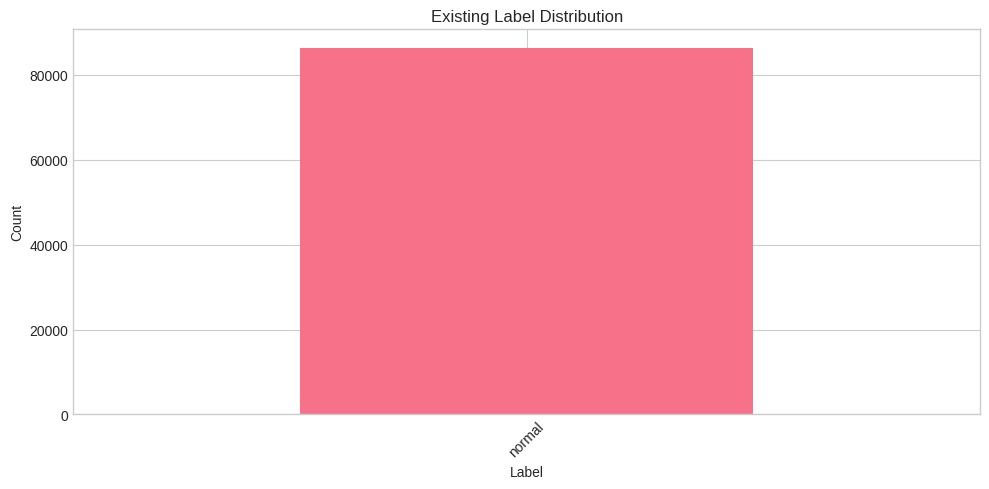

In [8]:
# Check existing labels if present
if EXISTING_LABEL_COL and EXISTING_LABEL_COL in df.columns:
    print(f"Existing label distribution ({EXISTING_LABEL_COL}):")
    print("="*40)
    label_counts = df[EXISTING_LABEL_COL].value_counts()
    for label, count in label_counts.items():
        pct = count / len(df) * 100
        print(f"  {label}: {count} ({pct:.1f}%)")
    
    # Visualize
    plt.figure(figsize=(10, 5))
    label_counts.plot(kind='bar', color=sns.color_palette("husl", len(label_counts)))
    plt.title('Existing Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No existing labels found - this is fine!")
    print("We will discover labels from the data.")

## 3. Prepare Features

In [9]:
# Identify feature columns (exclude metadata)
META_COLS = {
    'incident', 'window_start', 'window_end', 'timestamp', 'time',
    'label', 'label_rule', 'label_refined', 'label_discovered',
    'cluster', 'anomaly_score', 'source', 'collector'
}

# Get numeric columns that are not metadata
candidate_cols = [c for c in df.columns if c.lower() not in {m.lower() for m in META_COLS}]
feature_cols = df[candidate_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Identified {len(feature_cols)} feature columns:")
for i, col in enumerate(feature_cols):
    print(f"  {i+1}. {col}")

Identified 27 feature columns:
  1. announcements
  2. withdrawals
  3. nlri_ann
  4. dups
  5. origin_0
  6. origin_2
  7. origin_changes
  8. as_path_max
  9. unique_as_path_max
  10. edit_distance_avg
  11. edit_distance_max
  12. edit_distance_dict_0
  13. edit_distance_dict_1
  14. edit_distance_dict_2
  15. edit_distance_dict_3
  16. edit_distance_dict_4
  17. edit_distance_dict_5
  18. edit_distance_dict_6
  19. edit_distance_unique_dict_0
  20. edit_distance_unique_dict_1
  21. imp_wd
  22. imp_wd_spath
  23. imp_wd_dpath
  24. number_rare_ases
  25. rare_ases_avg
  26. flaps
  27. nadas


In [10]:
# Prepare feature matrix
X = df[feature_cols].values

# Handle missing values
valid_mask = ~np.isnan(X).any(axis=1)
X_valid = X[valid_mask]

print(f"Valid samples: {len(X_valid)} / {len(X)}")
print(f"Excluded due to NaN: {(~valid_mask).sum()}")

# Scale features (RobustScaler is robust to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_valid)

print(f"\nFeature matrix shape: {X_scaled.shape}")

Valid samples: 86400 / 86400
Excluded due to NaN: 0

Feature matrix shape: (86400, 27)


In [11]:
# ============================================
# HYPERPARAMETER CONFIGURATION
# ============================================
# These are the key parameters you can tune

# 1. Isolation Forest
N_ESTIMATORS = 200  # Number of trees (100-500, more = stable but slower)

# 2. Local Outlier Factor  
# Rule of thumb: sqrt(n_samples) or between 10-50
N_NEIGHBORS_LOF = max(10, min(50, int(np.sqrt(len(X_valid)))))

# 3. Statistical Outliers
IQR_MULTIPLIER = 1.5  # Standard=1.5, Conservative=2.0, Very Conservative=3.0
Z_SCORE_THRESHOLD = 3  # Standard=3, Conservative=2.5

# 4. PCA Components (for DBSCAN)
# Will be set based on variance explained

# 5. DBSCAN
MIN_SAMPLES_DBSCAN = 5  # Minimum points to form a cluster

print("Hyperparameters configured:")
print(f"  Isolation Forest n_estimators: {N_ESTIMATORS}")
print(f"  LOF n_neighbors: {N_NEIGHBORS_LOF} (based on sqrt({len(X_valid)}))")
print(f"  IQR multiplier: {IQR_MULTIPLIER}")
print(f"  Z-score threshold: {Z_SCORE_THRESHOLD}")
print(f"  DBSCAN min_samples: {MIN_SAMPLES_DBSCAN}")

Hyperparameters configured:
  Isolation Forest n_estimators: 200
  LOF n_neighbors: 50 (based on sqrt(86400))
  IQR multiplier: 1.5
  Z-score threshold: 3
  DBSCAN min_samples: 5


Tuning LOF n_neighbors...
  n_neighbors=5: 10.0% anomalies
  n_neighbors=10: 10.0% anomalies
  n_neighbors=15: 10.0% anomalies
  n_neighbors=20: 10.0% anomalies
  n_neighbors=30: 10.0% anomalies
  n_neighbors=40: 10.0% anomalies
  n_neighbors=50: 10.0% anomalies


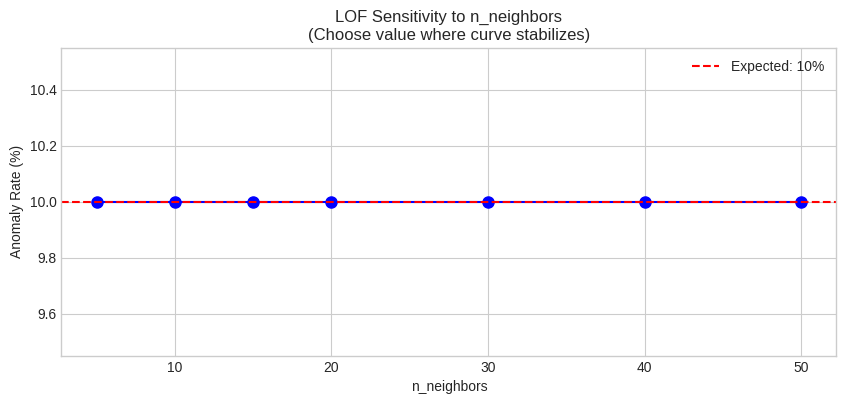


Recommended n_neighbors: 5


In [12]:
# Tune LOF n_neighbors using stability analysis
print("Tuning LOF n_neighbors...")

neighbor_range = [5, 10, 15, 20, 30, 40, 50]
neighbor_range = [n for n in neighbor_range if n < len(X_valid) // 2]  # Must be less than n_samples/2

lof_stability = []
for n in neighbor_range:
    lof_temp = LocalOutlierFactor(n_neighbors=n, contamination=CONTAMINATION_ESTIMATE)
    preds = lof_temp.fit_predict(X_scaled)
    anomaly_rate = (preds == -1).mean()
    lof_stability.append((n, anomaly_rate))
    print(f"  n_neighbors={n}: {anomaly_rate*100:.1f}% anomalies")

# Plot
plt.figure(figsize=(10, 4))
ns, rates = zip(*lof_stability)
plt.plot(ns, [r*100 for r in rates], 'bo-', markersize=8)
plt.axhline(y=CONTAMINATION_ESTIMATE*100, color='red', linestyle='--', 
            label=f'Expected: {CONTAMINATION_ESTIMATE*100:.0f}%')
plt.xlabel('n_neighbors')
plt.ylabel('Anomaly Rate (%)')
plt.title('LOF Sensitivity to n_neighbors\n(Choose value where curve stabilizes)')
plt.legend()
plt.grid(True)
plt.show()

# Find most stable value (closest to expected contamination)
best_n = min(lof_stability, key=lambda x: abs(x[1] - CONTAMINATION_ESTIMATE))[0]
print(f"\nRecommended n_neighbors: {best_n}")

Analyzing PCA variance...
  Components for 90% variance: 4
  Components for 95% variance: 7


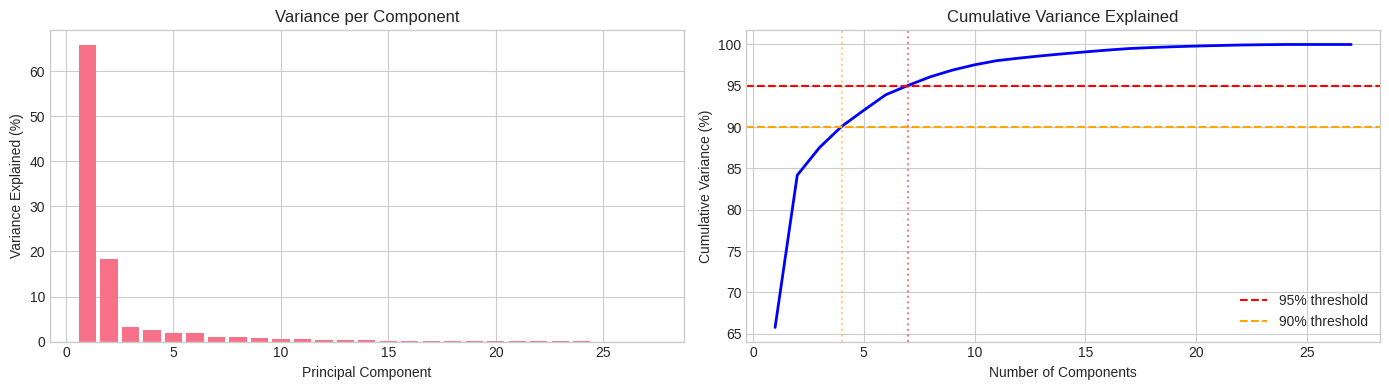


Using 7 PCA components (95% variance)


In [13]:
# Determine optimal PCA components (preserve 95% variance)
print("Analyzing PCA variance...")

pca_full = PCA()
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"  Components for 90% variance: {n_components_90}")
print(f"  Components for 95% variance: {n_components_95}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Individual variance
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
            pca_full.explained_variance_ratio_*100)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('Variance per Component')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance*100, 'b-', linewidth=2)
axes[1].axhline(y=95, color='red', linestyle='--', label='95% threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90% threshold')
axes[1].axvline(x=n_components_95, color='red', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_90, color='orange', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Set optimal PCA components
N_PCA_COMPONENTS = n_components_95
print(f"\nUsing {N_PCA_COMPONENTS} PCA components (95% variance)")

## 5. Anomaly Detection Methods (with tuned parameters)

Now we run the 5 methods using the parameters we tuned above.

In [14]:
# Method 1: Isolation Forest (using tuned parameters)
print("[1/5] Running Isolation Forest...")

iso_forest = IsolationForest(
    n_estimators=N_ESTIMATORS,  # Using tuned parameter
    contamination=CONTAMINATION_ESTIMATE,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_predictions = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.decision_function(X_scaled)

iso_anomalies = (iso_predictions == -1)
print(f"  Parameters: n_estimators={N_ESTIMATORS}")
print(f"  Found {iso_anomalies.sum()} anomalies ({iso_anomalies.mean()*100:.1f}%)")

[1/5] Running Isolation Forest...
  Parameters: n_estimators=200
  Found 8640 anomalies (10.0%)


In [15]:
# Method 2: Local Outlier Factor (using tuned parameters)
print("[2/5] Running Local Outlier Factor...")

lof = LocalOutlierFactor(
    n_neighbors=N_NEIGHBORS_LOF,  # Using tuned parameter
    contamination=CONTAMINATION_ESTIMATE,
    novelty=False
)

lof_predictions = lof.fit_predict(X_scaled)
lof_scores = lof.negative_outlier_factor_

lof_anomalies = (lof_predictions == -1)
print(f"  Parameters: n_neighbors={N_NEIGHBORS_LOF}")
print(f"  Found {lof_anomalies.sum()} anomalies ({lof_anomalies.mean()*100:.1f}%)")

[2/5] Running Local Outlier Factor...
  Parameters: n_neighbors=50
  Found 8640 anomalies (10.0%)


In [16]:
# Method 3: Statistical Analysis (using tuned parameters)
print("[3/5] Running Statistical Analysis...")

def statistical_outlier_scores(X, z_threshold=3, iqr_mult=1.5):
    """Calculate outlier scores using Z-score and IQR."""
    n_samples, n_features = X.shape
    outlier_scores = np.zeros(n_samples)
    
    for i in range(n_features):
        col = X[:, i]
        
        # Z-score method (tunable threshold)
        z_scores = np.abs(stats.zscore(col, nan_policy='omit'))
        z_outliers = z_scores > z_threshold
        
        # IQR method (tunable multiplier)
        Q1, Q3 = np.percentile(col, [25, 75])
        IQR = Q3 - Q1
        iqr_outliers = (col < Q1 - iqr_mult * IQR) | (col > Q3 + iqr_mult * IQR)
        
        outlier_scores += z_outliers.astype(float) + iqr_outliers.astype(float)
    
    return outlier_scores / (2 * n_features)

# Use tuned parameters
stat_scores = statistical_outlier_scores(X_valid, 
                                          z_threshold=Z_SCORE_THRESHOLD,
                                          iqr_mult=IQR_MULTIPLIER)
stat_threshold = np.percentile(stat_scores, 100 * (1 - CONTAMINATION_ESTIMATE))
stat_anomalies = stat_scores > stat_threshold

print(f"  Parameters: Z-score threshold={Z_SCORE_THRESHOLD}, IQR multiplier={IQR_MULTIPLIER}")
print(f"  Found {stat_anomalies.sum()} anomalies ({stat_anomalies.mean()*100:.1f}%)")

[3/5] Running Statistical Analysis...
  Parameters: Z-score threshold=3, IQR multiplier=1.5
  Found 8076 anomalies (9.3%)


In [17]:
# Method 4: Elliptic Envelope (Robust Covariance)
print("[4/5] Running Elliptic Envelope...")

try:
    elliptic = EllipticEnvelope(
        contamination=CONTAMINATION_ESTIMATE,
        random_state=RANDOM_STATE
    )
    elliptic_predictions = elliptic.fit_predict(X_scaled)
    elliptic_scores = elliptic.decision_function(X_scaled)
    elliptic_anomalies = (elliptic_predictions == -1)
    print(f"  Found {elliptic_anomalies.sum()} anomalies ({elliptic_anomalies.mean()*100:.1f}%)")
    elliptic_success = True
except Exception as e:
    print(f"  Skipped due to error: {e}")
    elliptic_anomalies = np.zeros(len(X_valid), dtype=bool)
    elliptic_scores = np.zeros(len(X_valid))
    elliptic_success = False

[4/5] Running Elliptic Envelope...
  Found 8640 anomalies (10.0%)


[5/5] Running HDBSCAN Clustering...
  PCA variance explained: 95.0%
  Running HDBSCAN on 86400 samples...
  Parameters: min_cluster_size=50, min_samples=5
  Found 10 clusters, 81640 noise points

  Using outlier_scores for anomaly detection:
  Outlier score threshold (top 10%): 0.682
  Anomalies detected: 8640 (10.0%)
  Saved: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/06_hdbscan_results.png


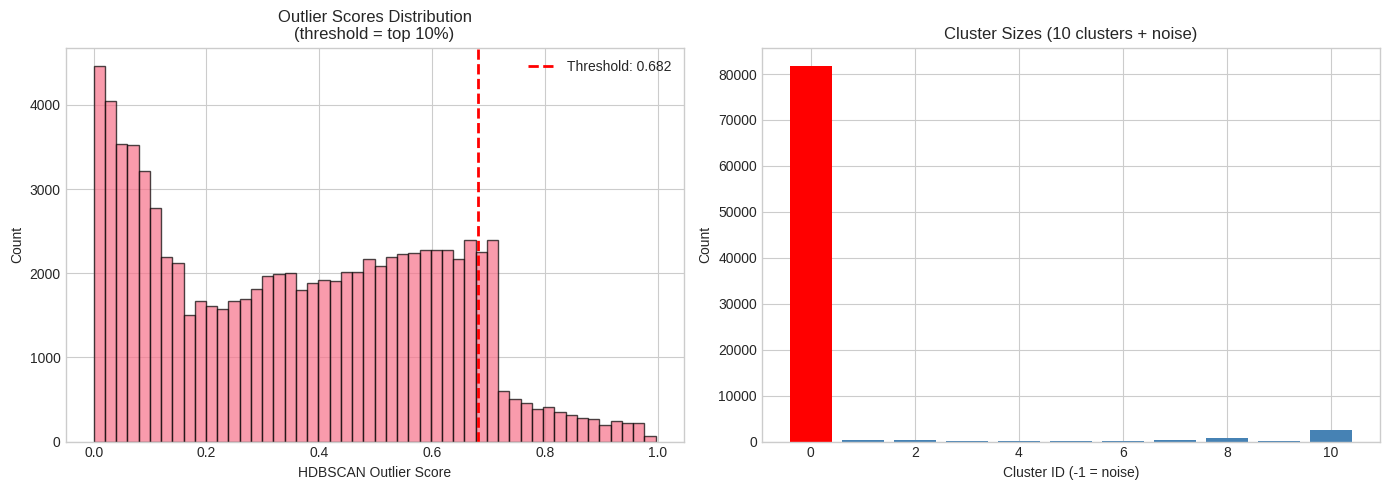

In [18]:
# Method 5: HDBSCAN (using outlier_scores, NOT cluster noise)
print("[5/5] Running HDBSCAN Clustering...")

# Install hdbscan if not available
try:
    import hdbscan
except ImportError:
    print("Installing hdbscan...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'hdbscan', '-q'])
    import hdbscan

import gc

# Use PCA with tuned components
pca = PCA(n_components=N_PCA_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)
print(f"  PCA variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# HDBSCAN parameters
MIN_CLUSTER_SIZE = 50   
MIN_SAMPLES = 5        

print(f"  Running HDBSCAN on {len(X_pca)} samples...")
print(f"  Parameters: min_cluster_size={MIN_CLUSTER_SIZE}, min_samples={MIN_SAMPLES}")

# HDBSCAN 
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    min_samples=MIN_SAMPLES,
    cluster_selection_method='leaf',
    prediction_data=False,
    core_dist_n_jobs=-1
)

hdbscan_labels = clusterer.fit_predict(X_pca)

# Get outlier scores
outlier_scores = clusterer.outlier_scores_

# Clean up
gc.collect()

# Calculate n_clusters (THIS WAS MISSING!)
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
noise_count = (hdbscan_labels == -1).sum()
print(f"  Found {n_clusters} clusters, {noise_count} noise points")

# Use outlier_scores with threshold (NOT noise labels)
outlier_threshold = np.percentile(outlier_scores, 100 * (1 - CONTAMINATION_ESTIMATE))
hdbscan_anomalies = outlier_scores > outlier_threshold

anomaly_rate = hdbscan_anomalies.mean() * 100
print(f"\n  Using outlier_scores for anomaly detection:")
print(f"  Outlier score threshold (top {CONTAMINATION_ESTIMATE*100:.0f}%): {outlier_threshold:.3f}")
print(f"  Anomalies detected: {hdbscan_anomalies.sum()} ({anomaly_rate:.1f}%)")

# Store for later use
dbscan_anomalies = hdbscan_anomalies
dbscan_labels = hdbscan_labels

# Show outlier score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Outlier score histogram
axes[0].hist(outlier_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=outlier_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Threshold: {outlier_threshold:.3f}')
axes[0].set_xlabel('HDBSCAN Outlier Score')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Outlier Scores Distribution\n(threshold = top {CONTAMINATION_ESTIMATE*100:.0f}%)')
axes[0].legend()

# Cluster sizes
cluster_counts = pd.Series(hdbscan_labels).value_counts().sort_index()
colors_bar = ['red' if idx == -1 else 'steelblue' for idx in cluster_counts.index]
axes[1].bar(range(len(cluster_counts)), cluster_counts.values, color=colors_bar)
axes[1].set_xlabel('Cluster ID (-1 = noise)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Cluster Sizes ({n_clusters} clusters + noise)')

plt.tight_layout()
save_plot(fig, '06_hdbscan_results')
plt.show()

## 5. Compute Consensus

In [19]:
# Count votes from all methods
n_methods = 5 if elliptic_success else 4

anomaly_votes = (
    iso_anomalies.astype(int) +
    lof_anomalies.astype(int) +
    stat_anomalies.astype(int) +
    elliptic_anomalies.astype(int) +
    dbscan_anomalies.astype(int)
)

consensus_score = anomaly_votes / n_methods

# Assign discovered labels based on consensus
discovered_labels = np.where(
    consensus_score >= 0.8, 'high_confidence_anomaly',
    np.where(
        consensus_score >= 0.5, 'likely_anomaly',
        np.where(
            consensus_score >= 0.2, 'uncertain',
            'likely_normal'
        )
    )
)

print("Consensus Results:")
print("="*50)
for label in ['likely_normal', 'uncertain', 'likely_anomaly', 'high_confidence_anomaly']:
    count = (discovered_labels == label).sum()
    pct = count / len(discovered_labels) * 100
    emoji = "🟢" if 'normal' in label else "🔴" if 'anomaly' in label else "🟡"
    print(f"  {emoji} {label}: {count} ({pct:.1f}%)")

Consensus Results:
  🟢 likely_normal: 65820 (76.2%)
  🟡 uncertain: 14247 (16.5%)
  🔴 likely_anomaly: 1768 (2.0%)
  🔴 high_confidence_anomaly: 4565 (5.3%)


  Saved: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/01_consensus_distribution.png


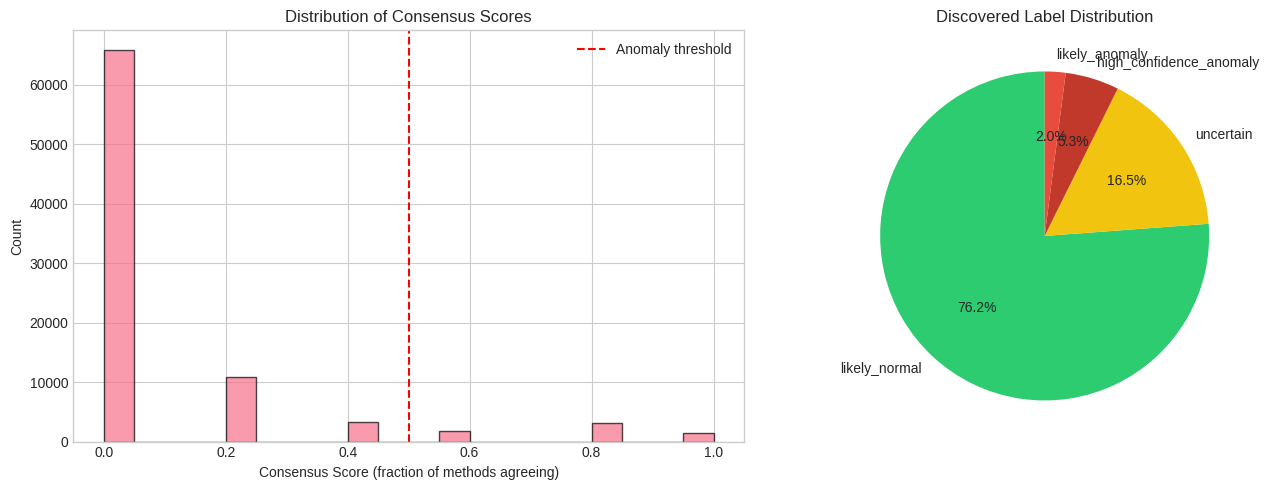

In [20]:
# Visualize consensus distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of consensus scores
axes[0].hist(consensus_score, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Consensus Score (fraction of methods agreeing)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Consensus Scores')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Anomaly threshold')
axes[0].legend()

# Pie chart of discovered labels
label_counts = pd.Series(discovered_labels).value_counts()
colors = {'likely_normal': '#2ecc71', 'uncertain': '#f1c40f', 
          'likely_anomaly': '#e74c3c', 'high_confidence_anomaly': '#c0392b'}
pie_colors = [colors[l] for l in label_counts.index]
axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            colors=pie_colors, startangle=90)
axes[1].set_title('Discovered Label Distribution')

plt.tight_layout()
save_plot(fig, '01_consensus_distribution')
plt.show()

## 6. Method Agreement Analysis

  Saved: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/02_method_agreement_heatmap.png


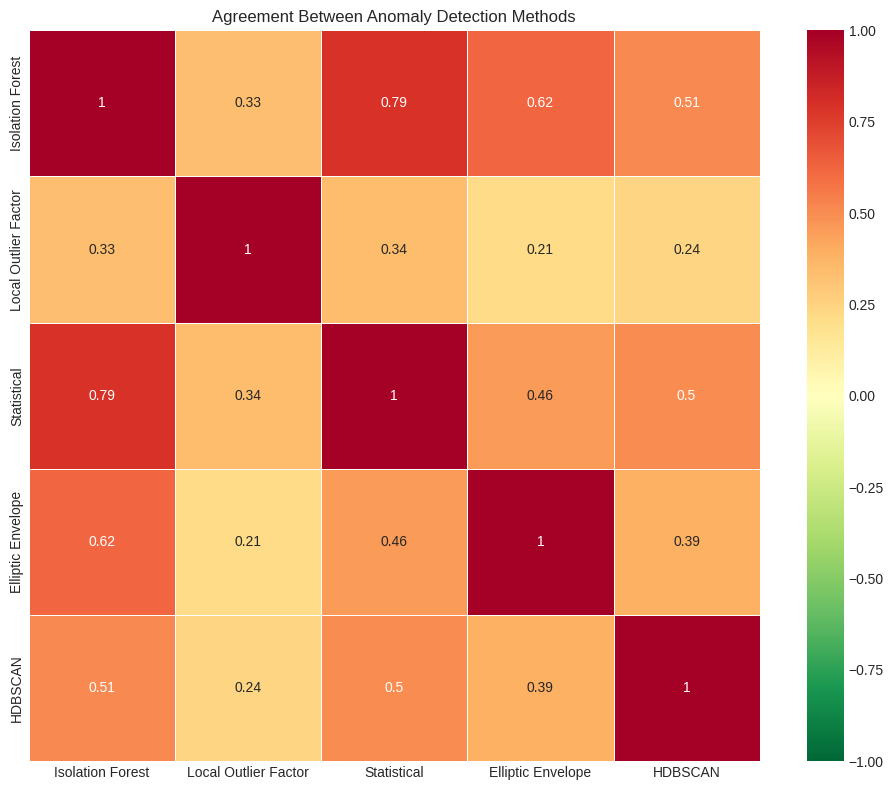


Per-method anomaly rates:
  Isolation Forest: 10.0%
  Local Outlier Factor: 10.0%
  Statistical: 9.3%
  Elliptic Envelope: 10.0%
  HDBSCAN: 10.0%


In [21]:
# Create agreement matrix
methods_df = pd.DataFrame({
    'Isolation Forest': iso_anomalies,
    'Local Outlier Factor': lof_anomalies,
    'Statistical': stat_anomalies,
    'Elliptic Envelope': elliptic_anomalies,
    'HDBSCAN': dbscan_anomalies
})

# Correlation between methods
fig, ax = plt.subplots(figsize=(10, 8))
correlation = methods_df.corr()
sns.heatmap(correlation, annot=True, cmap='RdYlGn_r', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax)
plt.title('Agreement Between Anomaly Detection Methods')
plt.tight_layout()
save_plot(fig, '02_method_agreement_heatmap')
plt.show()

print("\nPer-method anomaly rates:")
for col in methods_df.columns:
    rate = methods_df[col].mean() * 100
    print(f"  {col}: {rate:.1f}%")

## 7. K-Means Clustering Analysis

Finding optimal number of clusters...
  k=2: silhouette score = 0.9643
  k=3: silhouette score = 0.8555
  k=4: silhouette score = 0.7292
  k=5: silhouette score = 0.7100
  k=6: silhouette score = 0.7145
  k=7: silhouette score = 0.7074
  k=8: silhouette score = 0.7081
  k=9: silhouette score = 0.6494
  k=10: silhouette score = 0.6433

Optimal number of clusters: 2
  Saved: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/03_silhouette_scores.png


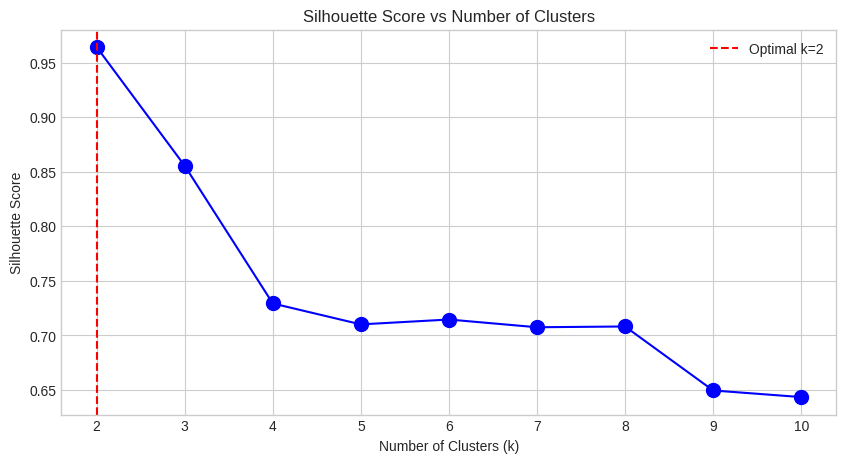

In [22]:
# Find optimal number of clusters using silhouette score
print("Finding optimal number of clusters...")

max_clusters = min(10, len(X_scaled) - 1)
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append((k, score))
    print(f"  k={k}: silhouette score = {score:.4f}")

optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"\nOptimal number of clusters: {optimal_k}")

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(10, 5))
ks, scores = zip(*silhouette_scores)
ax.plot(ks, scores, 'bo-', markersize=10)
ax.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs Number of Clusters')
ax.legend()
ax.grid(True)
save_plot(fig, '03_silhouette_scores')
plt.show()

In [23]:
# Perform final clustering with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

print(f"Cluster distribution:")
for i in range(optimal_k):
    count = (cluster_labels == i).sum()
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {i}: {count} samples ({pct:.1f}%)")

Cluster distribution:
  Cluster 0: 86200 samples (99.8%)
  Cluster 1: 200 samples (0.2%)


  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/04_pca_clusters_anomalies.png


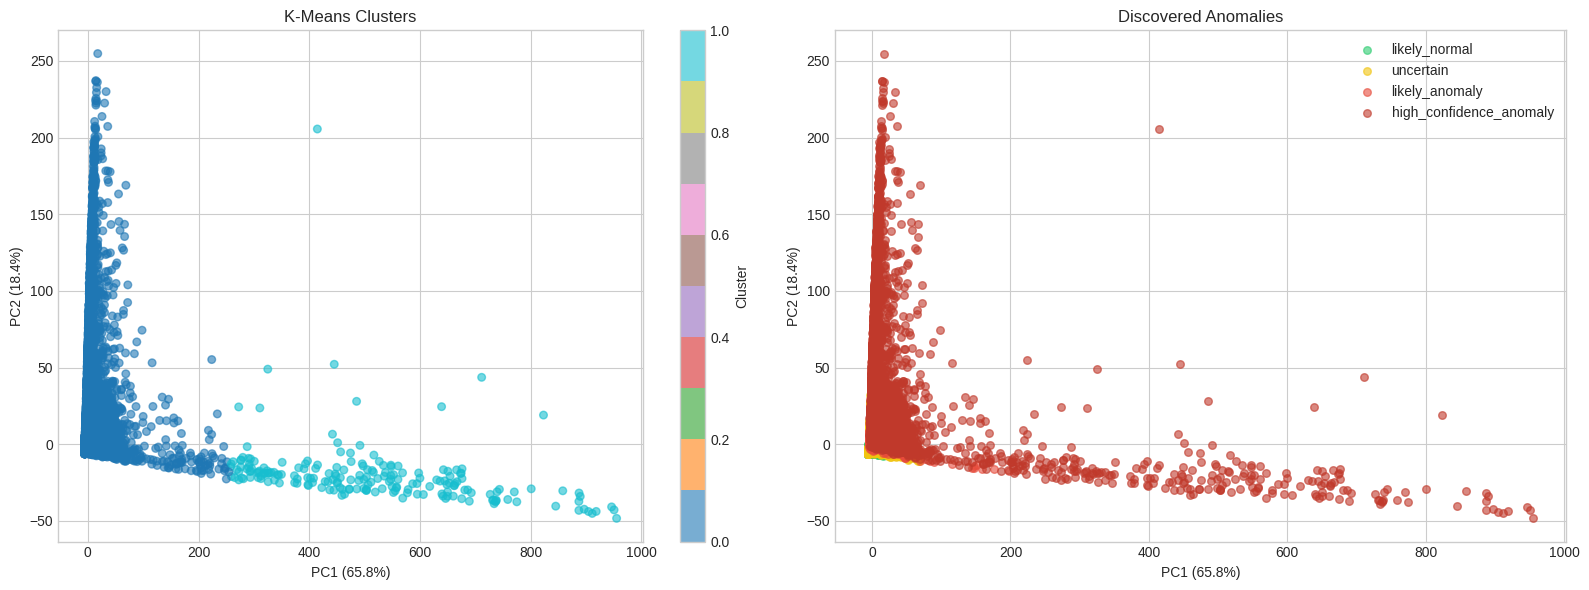

In [21]:
# Visualize clusters using PCA
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-Means clusters
scatter1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
                           cmap='tab10', alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('K-Means Clusters')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Discovered anomalies
colors = {'likely_normal': '#2ecc71', 'uncertain': '#f1c40f', 
          'likely_anomaly': '#e74c3c', 'high_confidence_anomaly': '#c0392b'}
for label in ['likely_normal', 'uncertain', 'likely_anomaly', 'high_confidence_anomaly']:
    mask = discovered_labels == label
    axes[1].scatter(X_2d[mask, 0], X_2d[mask, 1], c=colors[label], 
                    label=label, alpha=0.6, s=30)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('Discovered Anomalies')
axes[1].legend()

plt.tight_layout()
save_plot(fig, '04_pca_clusters_anomalies')
plt.show()

## 8. Feature Analysis: What Makes Anomalies Different?

In [24]:
# Compare features between normal and anomalous samples
normal_mask = discovered_labels == 'likely_normal'
anomaly_mask = np.isin(discovered_labels, ['high_confidence_anomaly', 'likely_anomaly'])

feature_analysis = []

for i, col in enumerate(feature_cols):
    normal_vals = X_valid[normal_mask, i]
    anomaly_vals = X_valid[anomaly_mask, i]
    
    if len(normal_vals) > 0 and len(anomaly_vals) > 0:
        normal_mean = np.mean(normal_vals)
        anomaly_mean = np.mean(anomaly_vals)
        
        # Cohen's d effect size
        pooled_std = np.sqrt((np.std(normal_vals)**2 + np.std(anomaly_vals)**2) / 2)
        if pooled_std > 0:
            effect_size = abs(anomaly_mean - normal_mean) / pooled_std
        else:
            effect_size = 0
        
        feature_analysis.append({
            'feature': col,
            'normal_mean': normal_mean,
            'anomaly_mean': anomaly_mean,
            'difference': anomaly_mean - normal_mean,
            'effect_size': effect_size,
            'direction': 'higher' if anomaly_mean > normal_mean else 'lower'
        })

# Sort by effect size
feature_analysis = sorted(feature_analysis, key=lambda x: x['effect_size'], reverse=True)

print("Top 10 Most Discriminative Features:")
print("="*70)
print(f"{'Feature':<30} {'Effect Size':>12} {'Direction':>10} {'Normal':>10} {'Anomaly':>10}")
print("-"*70)
for item in feature_analysis[:10]:
    print(f"{item['feature']:<30} {item['effect_size']:>12.3f} {item['direction']:>10} "
          f"{item['normal_mean']:>10.2f} {item['anomaly_mean']:>10.2f}")

Top 10 Most Discriminative Features:
Feature                         Effect Size  Direction     Normal    Anomaly
----------------------------------------------------------------------
rare_ases_avg                         1.673      lower       0.05       0.02
edit_distance_unique_dict_1           1.297     higher      16.48     169.68
imp_wd                                1.222     higher      21.01     196.76
imp_wd_dpath                          1.170     higher      15.00     114.99
edit_distance_dict_1                  1.087     higher      25.90     355.77
flaps                                 1.010     higher       5.76     112.26
edit_distance_unique_dict_0           1.001     higher       5.77      58.46
withdrawals                           0.988     higher      19.36     262.74
imp_wd_spath                          0.912     higher       6.02      81.76
edit_distance_dict_0                  0.891     higher       8.66      92.03


  Saved: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/05_feature_distributions.png


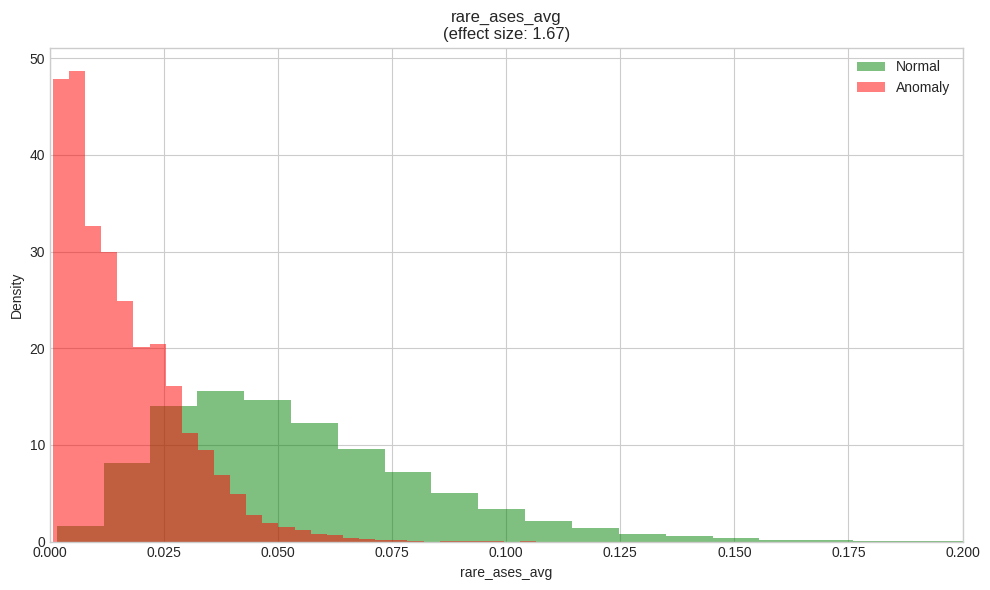

In [34]:
top_features = [f['feature'] for f in feature_analysis[:1]]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for the single top feature
feat = top_features[0]
feat_idx = feature_cols.index(feat)

normal_vals = X_valid[normal_mask, feat_idx]
anomaly_vals = X_valid[anomaly_mask, feat_idx]

ax.hist(normal_vals, bins=30, alpha=0.5, label='Normal', color='green', density=True)
ax.hist(anomaly_vals, bins=30, alpha=0.5, label='Anomaly', color='red', density=True)
ax.set_xlabel(feat)
ax.set_ylabel('Density')
ax.set_title(f'{feat}\n(effect size: {feature_analysis[0]["effect_size"]:.2f})')
ax.legend()
ax.set_xlim(0, 0.20)      # <-- here

plt.tight_layout()
save_plot(fig, '05_feature_distributions')
fig.savefig('05_feature_distributions.pdf')  # save as PDF

plt.show()


## 9. Temporal Analysis (if time column exists)

  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/07_temporal_analysis.png


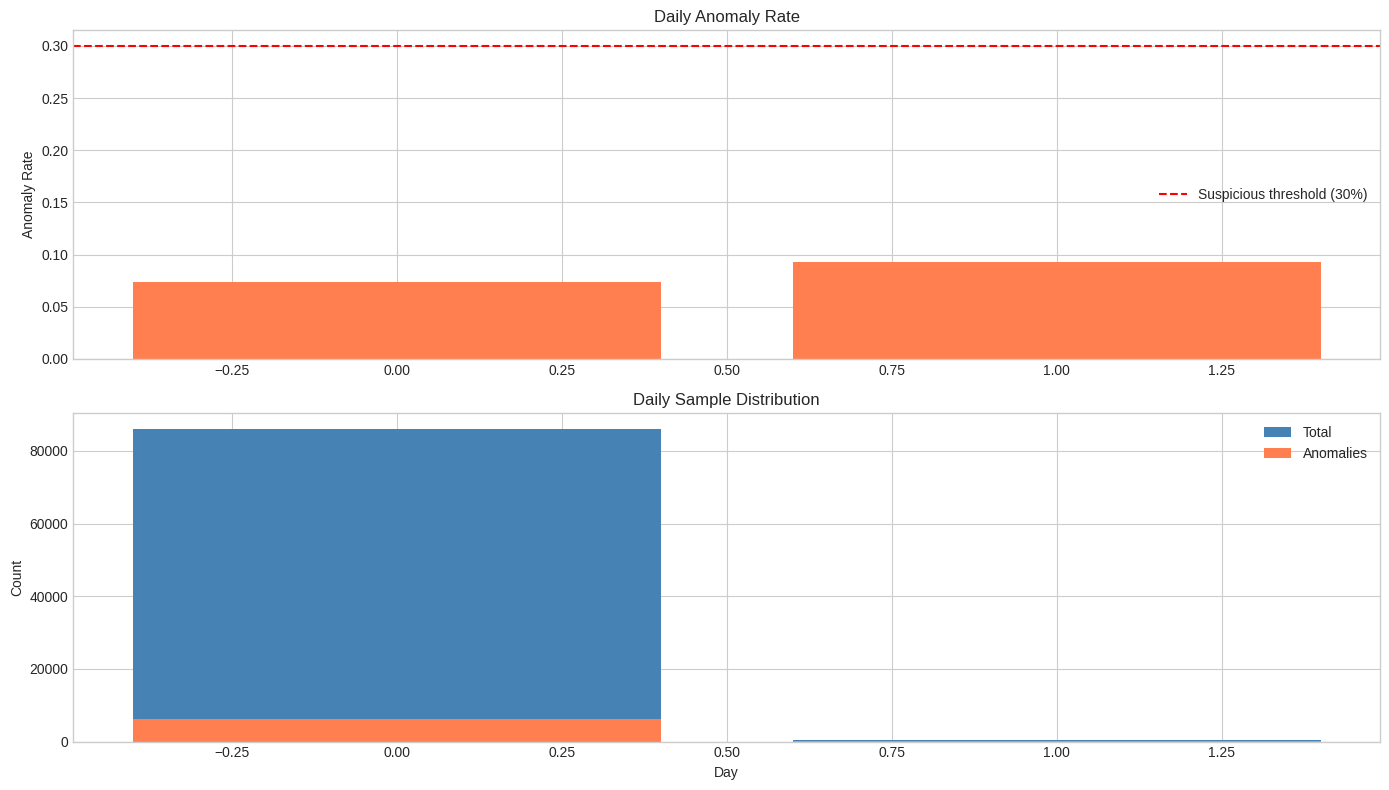


✅ No suspicious time periods found.


In [24]:
if TIME_COL and TIME_COL in df.columns:
    # Create results dataframe for valid samples only
    results_df = df.loc[valid_mask].copy()
    results_df['discovered_label'] = discovered_labels
    results_df['consensus_score'] = consensus_score
    
    # Parse timestamps
    results_df[TIME_COL] = pd.to_datetime(results_df[TIME_COL], errors='coerce')
    results_df = results_df.dropna(subset=[TIME_COL])
    
    if len(results_df) > 0:
        # Group by day
        results_df['date'] = results_df[TIME_COL].dt.date
        
        daily_stats = results_df.groupby('date').agg({
            'consensus_score': ['count', 'mean'],
            'discovered_label': lambda x: x.isin(['high_confidence_anomaly', 'likely_anomaly']).sum()
        }).reset_index()
        daily_stats.columns = ['date', 'total', 'avg_score', 'anomalies']
        daily_stats['anomaly_rate'] = daily_stats['anomalies'] / daily_stats['total']
        
        # Plot temporal distribution
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        
        # Plot 1: Daily anomaly rate
        axes[0].bar(range(len(daily_stats)), daily_stats['anomaly_rate'], color='coral')
        axes[0].set_ylabel('Anomaly Rate')
        axes[0].set_title('Daily Anomaly Rate')
        axes[0].axhline(y=0.3, color='red', linestyle='--', label='Suspicious threshold (30%)')
        axes[0].legend()
        
        # Plot 2: Daily sample count
        axes[1].bar(range(len(daily_stats)), daily_stats['total'], color='steelblue', label='Total')
        axes[1].bar(range(len(daily_stats)), daily_stats['anomalies'], color='coral', label='Anomalies')
        axes[1].set_xlabel('Day')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Daily Sample Distribution')
        axes[1].legend()
        
        plt.tight_layout()
        save_plot(fig, '07_temporal_analysis')
        plt.show()
        
        # Find suspicious periods
        suspicious = daily_stats[daily_stats['anomaly_rate'] > 0.3]
        if len(suspicious) > 0:
            print("\n⚠️ SUSPICIOUS PERIODS (>30% anomaly rate):")
            for _, row in suspicious.iterrows():
                print(f"   {row['date']}: {row['anomalies']}/{row['total']} anomalies ({row['anomaly_rate']*100:.1f}%)")
        else:
            print("\n✅ No suspicious time periods found.")
else:
    print("No time column available for temporal analysis.")

## 9.1 Enhanced Time-Series Validation for "Likely Normal" Traffic

This section provides detailed time-series analysis to validate that samples labeled as "likely normal" truly exhibit stable, expected behavior without hidden peaks or anomalies.

In [25]:
# ============================================
# TIME-SERIES VALIDATION CONFIGURATION
# ============================================

# Key features to analyze in time-series (most indicative of BGP anomalies)
KEY_FEATURES_TIMESERIES = [
    'announcements', 'withdrawals', 'flaps', 'nadas',
    'origin_changes', 'imp_wd', 'number_rare_ases',
    'edit_distance_avg', 'as_path_max'
]

# Rolling window size (in samples - adjust based on your time resolution)
ROLLING_WINDOW = 60  # e.g., 60 samples = 1 hour if 1-minute windows

# Peak detection thresholds
PEAK_STD_THRESHOLD = 3.0  # Flag values > mean + 3*std as peaks
SPIKE_PERCENTILE = 99  # Flag values above 99th percentile

# Filter to only available features
KEY_FEATURES_TIMESERIES = [f for f in KEY_FEATURES_TIMESERIES if f in feature_cols]

print(f"Time-Series Analysis Configuration:")
print(f"  Key features: {len(KEY_FEATURES_TIMESERIES)}")
print(f"  Rolling window: {ROLLING_WINDOW} samples")
print(f"  Peak threshold: mean + {PEAK_STD_THRESHOLD}*std")
print(f"  Spike percentile: {SPIKE_PERCENTILE}%")

Time-Series Analysis Configuration:
  Key features: 9
  Rolling window: 60 samples
  Peak threshold: mean + 3.0*std
  Spike percentile: 99%


In [26]:
# Prepare time-series data for "likely normal" samples
print("Preparing time-series data for 'likely normal' samples...")

# Create analysis dataframe
ts_df = df.loc[valid_mask].copy()
ts_df['discovered_label'] = discovered_labels
ts_df['consensus_score'] = consensus_score

# Parse timestamps
if TIME_COL and TIME_COL in ts_df.columns:
    ts_df[TIME_COL] = pd.to_datetime(ts_df[TIME_COL], errors='coerce')
    ts_df = ts_df.dropna(subset=[TIME_COL])
    ts_df = ts_df.sort_values(TIME_COL).reset_index(drop=True)
    has_time = True
    print(f"  Time range: {ts_df[TIME_COL].min()} to {ts_df[TIME_COL].max()}")
else:
    # Use sample index as time proxy
    ts_df['sample_index'] = range(len(ts_df))
    TIME_COL_USE = 'sample_index'
    has_time = False
    print("  No time column - using sample index as time proxy")

TIME_COL_USE = TIME_COL if has_time else 'sample_index'

# Filter to likely normal samples
normal_df = ts_df[ts_df['discovered_label'] == 'likely_normal'].copy()
print(f"  'Likely normal' samples: {len(normal_df)} ({len(normal_df)/len(ts_df)*100:.1f}%)")

# Also keep anomaly samples for comparison
anomaly_df = ts_df[ts_df['discovered_label'].isin(['high_confidence_anomaly', 'likely_anomaly'])].copy()
print(f"  Anomaly samples for comparison: {len(anomaly_df)}")

Preparing time-series data for 'likely normal' samples...
  Time range: 2025-12-16 00:05:00 to 2025-12-17 00:04:59
  'Likely normal' samples: 65819 (76.2%)
  Anomaly samples for comparison: 6332


Generating individual feature time-series plots with rolling statistics...
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/09_timeseries_individual_features.png


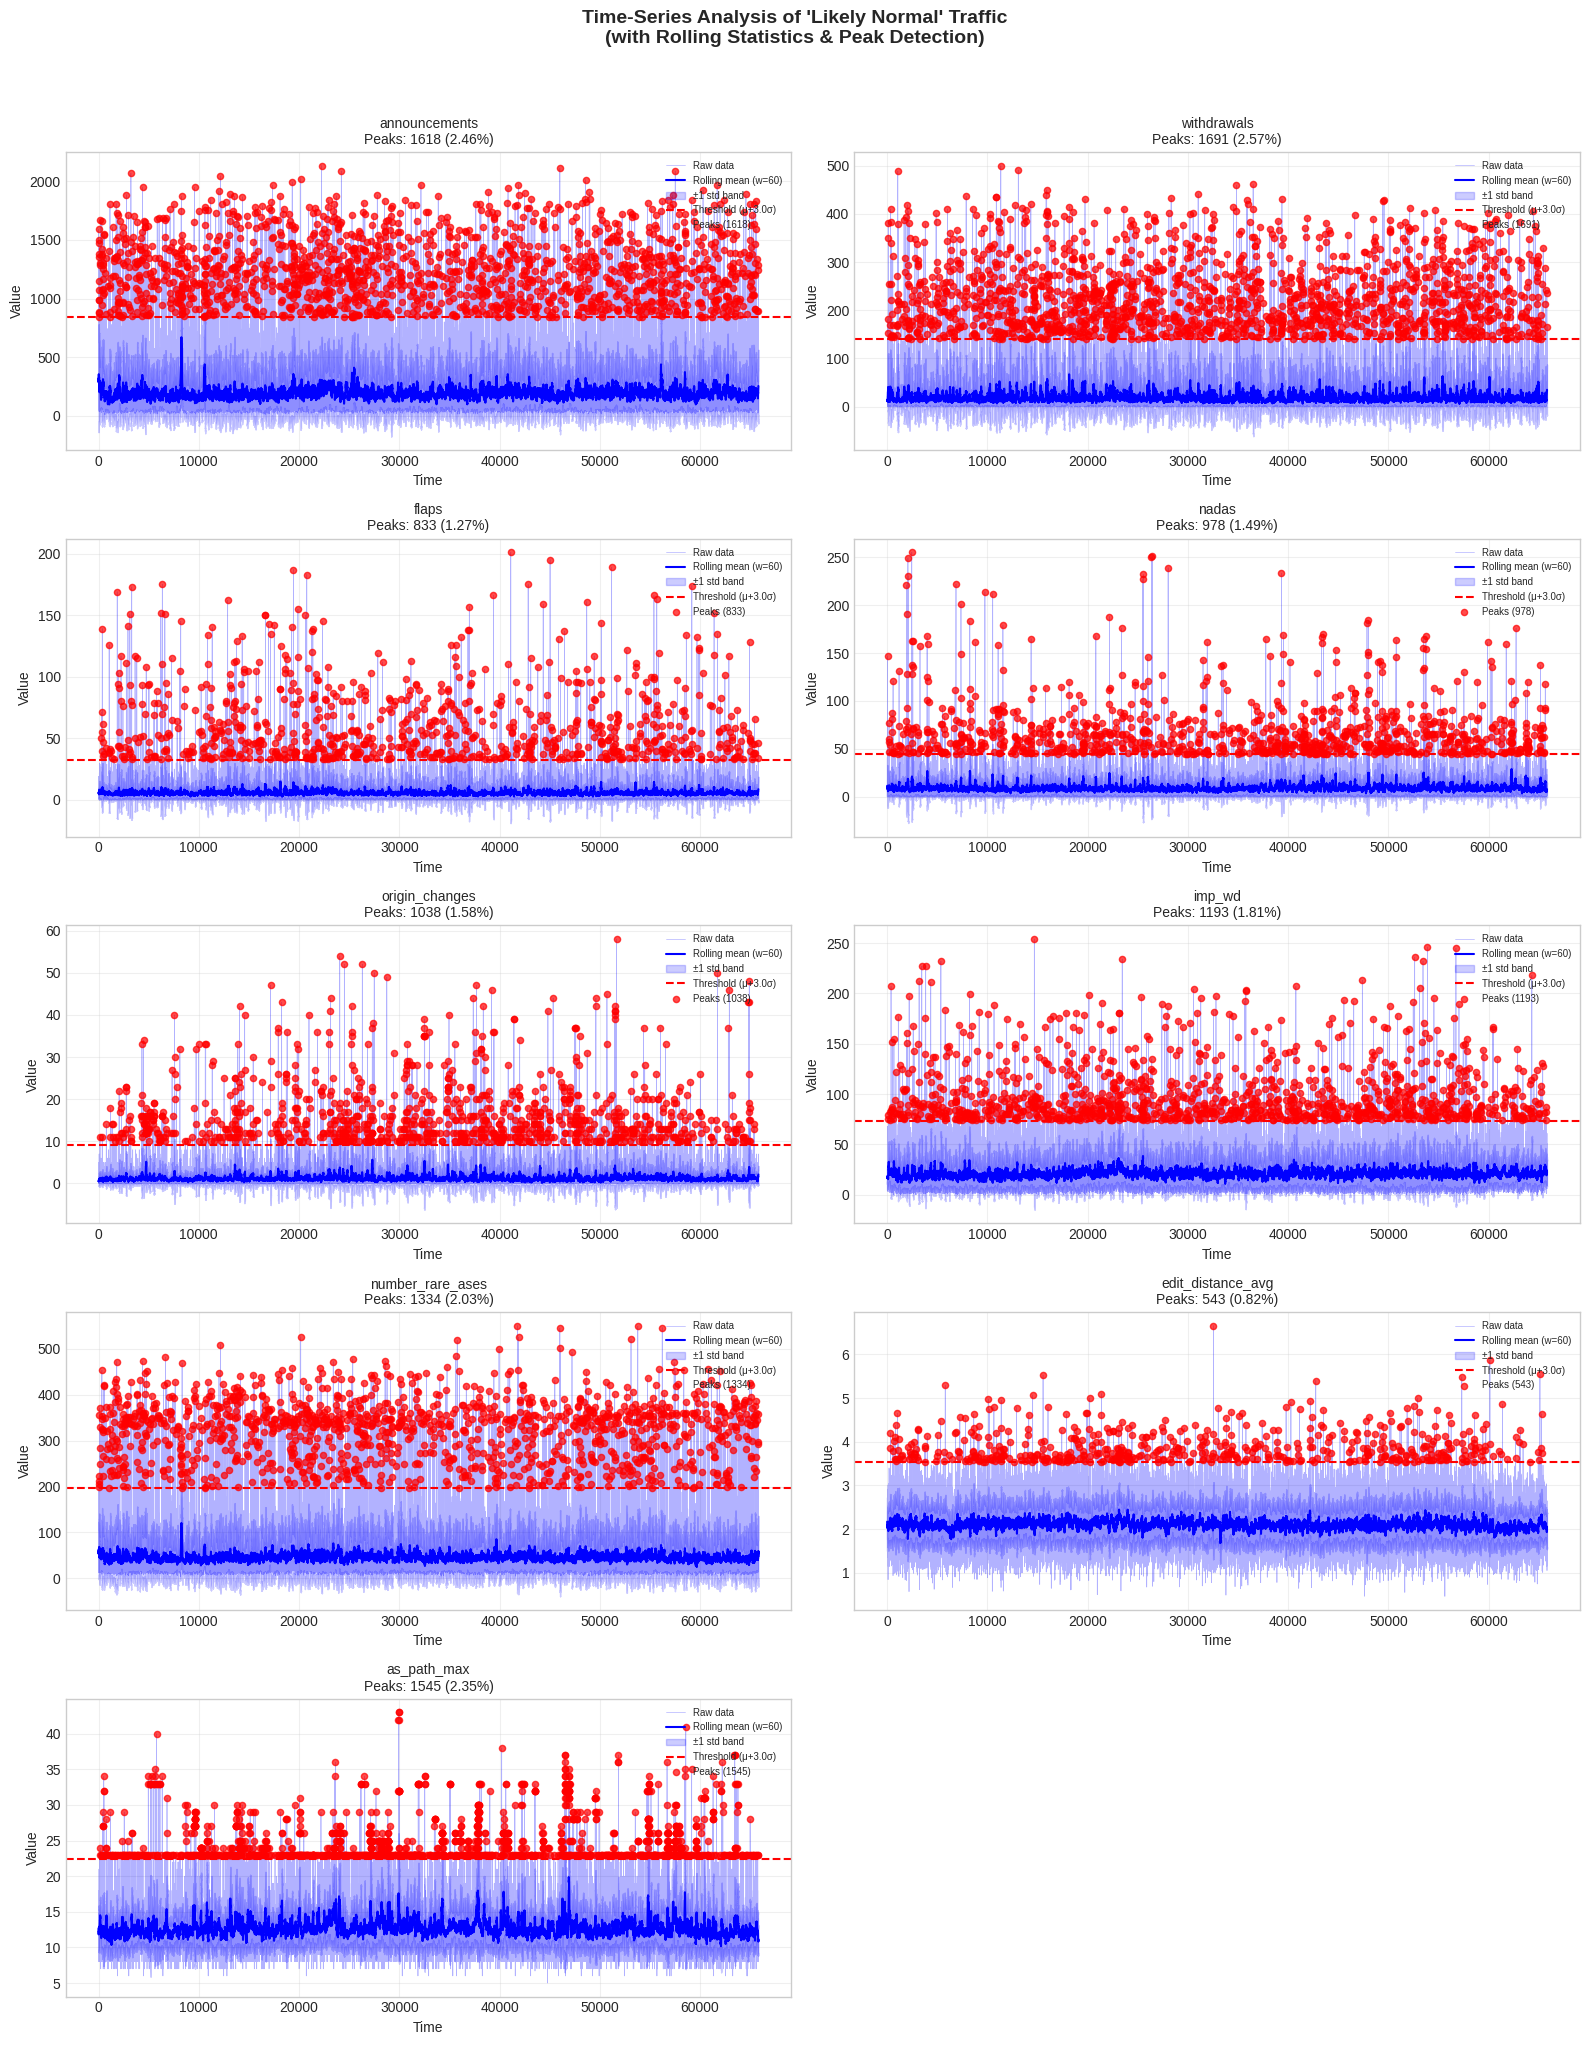


PEAK DETECTION SUMMARY FOR 'LIKELY NORMAL' TRAFFIC
Feature                      Peaks     Peak %         Mean    Threshold
----------------------------------------------------------------------
withdrawals                   1691      2.57%        19.36       139.62
announcements                 1618      2.46%       193.02       839.29
as_path_max                   1545      2.35%        12.71        22.44
number_rare_ases              1334      2.03%        46.36       195.80
imp_wd                        1193      1.81%        21.01        73.39
origin_changes                1038      1.58%         1.24         9.21
nadas                          978      1.49%         9.13        44.23
flaps                          833      1.27%         5.76        32.11
edit_distance_avg              543      0.82%         2.11         3.53

⚠️  ATTENTION: Features with >1% peaks in 'likely normal': ['withdrawals', 'announcements', 'as_path_max', 'number_rare_ases', 'imp_wd', 'origin_changes', '

In [27]:
# ============================================
# INDIVIDUAL FEATURE TIME-SERIES WITH ROLLING STATISTICS
# ============================================
print("Generating individual feature time-series plots with rolling statistics...")

n_features = len(KEY_FEATURES_TIMESERIES)
n_cols = 2
n_rows = (n_features + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

peak_summary = {}

for i, feature in enumerate(KEY_FEATURES_TIMESERIES):
    ax = axes[i]
    
    # Get data for this feature
    if feature not in normal_df.columns:
        continue
    
    x_vals = normal_df[TIME_COL_USE].values
    y_vals = normal_df[feature].values
    
    # Calculate rolling statistics
    series = pd.Series(y_vals)
    rolling_mean = series.rolling(window=ROLLING_WINDOW, center=True, min_periods=1).mean()
    rolling_std = series.rolling(window=ROLLING_WINDOW, center=True, min_periods=1).std()
    
    # Calculate thresholds
    global_mean = np.mean(y_vals)
    global_std = np.std(y_vals)
    upper_threshold = global_mean + PEAK_STD_THRESHOLD * global_std
    percentile_threshold = np.percentile(y_vals, SPIKE_PERCENTILE)
    
    # Detect peaks
    peaks_mask = y_vals > upper_threshold
    spikes_mask = y_vals > percentile_threshold
    n_peaks = peaks_mask.sum()
    n_spikes = spikes_mask.sum()
    
    peak_summary[feature] = {
        'n_peaks': n_peaks,
        'n_spikes': n_spikes,
        'peak_pct': n_peaks / len(y_vals) * 100,
        'max_value': np.max(y_vals),
        'mean': global_mean,
        'std': global_std,
        'threshold': upper_threshold
    }
    
    # Plot raw data
    ax.plot(range(len(y_vals)), y_vals, 'b-', alpha=0.3, linewidth=0.5, label='Raw data')
    
    # Plot rolling mean
    ax.plot(range(len(y_vals)), rolling_mean, 'b-', linewidth=1.5, label=f'Rolling mean (w={ROLLING_WINDOW})')
    
    # Plot rolling mean ± std band
    ax.fill_between(range(len(y_vals)), 
                    rolling_mean - rolling_std, 
                    rolling_mean + rolling_std, 
                    alpha=0.2, color='blue', label='±1 std band')
    
    # Plot threshold line
    ax.axhline(y=upper_threshold, color='red', linestyle='--', linewidth=1.5, 
               label=f'Threshold (μ+{PEAK_STD_THRESHOLD}σ)')
    
    # Highlight peaks
    if n_peaks > 0:
        peak_indices = np.where(peaks_mask)[0]
        ax.scatter(peak_indices, y_vals[peaks_mask], color='red', s=20, zorder=5, 
                   label=f'Peaks ({n_peaks})', alpha=0.7)
    
    ax.set_title(f'{feature}\nPeaks: {n_peaks} ({n_peaks/len(y_vals)*100:.2f}%)', fontsize=10)
    ax.set_xlabel('Sample Index' if not has_time else 'Time')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Time-Series Analysis of 'Likely Normal' Traffic\n(with Rolling Statistics & Peak Detection)", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_plot(fig, '09_timeseries_individual_features')
plt.show()

# Print peak summary
print("\n" + "="*70)
print("PEAK DETECTION SUMMARY FOR 'LIKELY NORMAL' TRAFFIC")
print("="*70)
print(f"{'Feature':<25} {'Peaks':>8} {'Peak %':>10} {'Mean':>12} {'Threshold':>12}")
print("-"*70)

suspicious_features = []
for feat, stats in sorted(peak_summary.items(), key=lambda x: -x[1]['peak_pct']):
    print(f"{feat:<25} {stats['n_peaks']:>8} {stats['peak_pct']:>9.2f}% {stats['mean']:>12.2f} {stats['threshold']:>12.2f}")
    if stats['peak_pct'] > 1.0:  # Flag if more than 1% are peaks
        suspicious_features.append(feat)

if suspicious_features:
    print(f"\n⚠️  ATTENTION: Features with >1% peaks in 'likely normal': {suspicious_features}")
else:
    print(f"\n✅ All features show <1% peaks in 'likely normal' traffic - good consistency!")

### 9.1.1 Detailed Peak & Spike Analysis

Examine samples in "likely normal" that show unusually high values to determine if they should be reclassified.

Analyzing peaks in 'likely normal' traffic...

Suspicious samples in 'likely normal' (max z-score > 3.0):
  Count: 8258 out of 65819 (12.55%)
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/10_peak_analysis_zscores.png


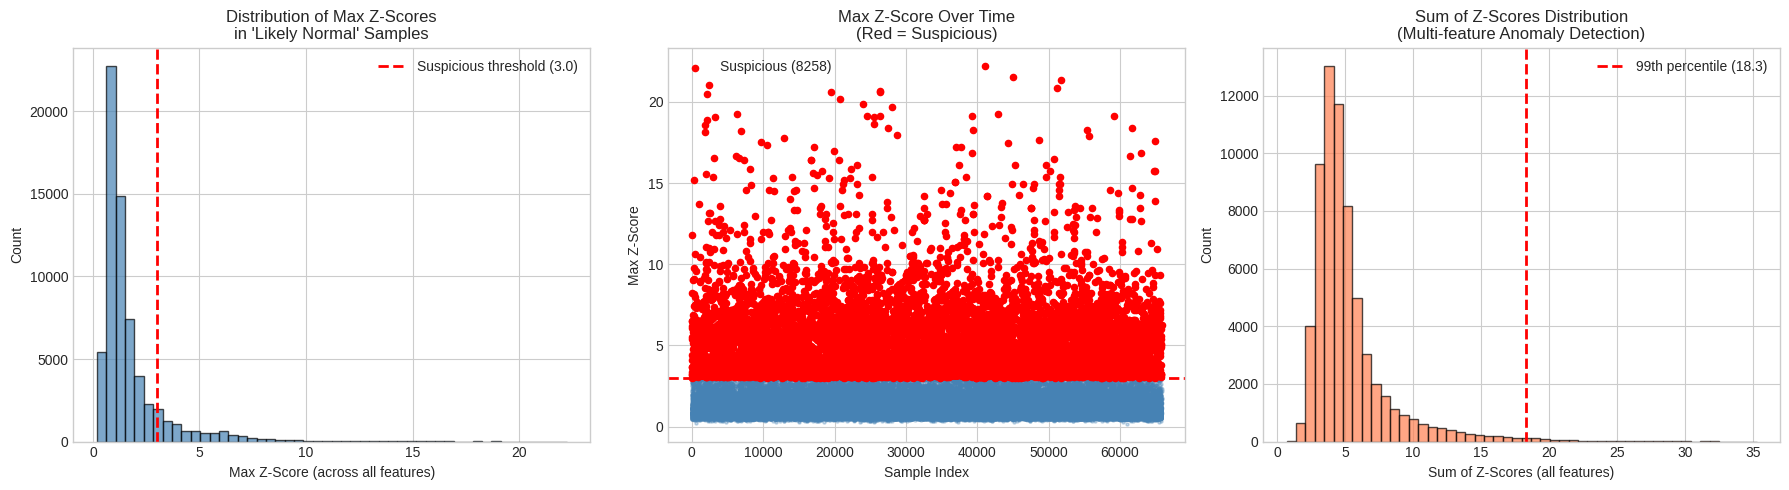


TOP 10 MOST SUSPICIOUS 'LIKELY NORMAL' SAMPLES (by max z-score)
             window_start  announcements  withdrawals  flaps  nadas  origin_changes  max_z_score
54163 2025-12-16 15:07:43            479          264    201     30               0    22.226977
59313 2025-12-16 16:33:33            856          195    195      2               0    21.543907
68095 2025-12-16 18:59:55            327            8      4      6              58    21.368944
3234  2025-12-16 00:58:54            967           15      3    255               2    21.017690
67358 2025-12-16 18:47:38            324          214    189     21               1    20.860838
34795 2025-12-16 09:44:55            817           17      2    251               0    20.675756
24975 2025-12-16 07:01:15            474          311    187     17               0    20.633148
34705 2025-12-16 09:43:25           1157            8      3    250               0    20.590273
2695  2025-12-16 00:49:55           1155           11      2  

In [28]:
# ============================================
# DETAILED PEAK ANALYSIS - IDENTIFY SUSPICIOUS "NORMAL" SAMPLES
# ============================================
print("Analyzing peaks in 'likely normal' traffic...")

# Compute z-scores for each feature across the likely normal samples
from scipy import stats as scipy_stats

# Create a composite anomaly score based on feature z-scores
normal_feature_data = normal_df[KEY_FEATURES_TIMESERIES].values
z_scores_normal = np.abs(scipy_stats.zscore(normal_feature_data, axis=0, nan_policy='omit'))

# Replace NaN with 0 (can happen with constant features)
z_scores_normal = np.nan_to_num(z_scores_normal, 0)

# Max z-score across all features for each sample
max_z_scores = np.max(z_scores_normal, axis=1)

# Sum of z-scores (captures samples that are moderately high across many features)
sum_z_scores = np.sum(z_scores_normal, axis=1)

# Identify potentially suspicious samples
suspicious_threshold = PEAK_STD_THRESHOLD
suspicious_mask = max_z_scores > suspicious_threshold

print(f"\nSuspicious samples in 'likely normal' (max z-score > {suspicious_threshold}):")
print(f"  Count: {suspicious_mask.sum()} out of {len(normal_df)} ({suspicious_mask.sum()/len(normal_df)*100:.2f}%)")

# Visualize distribution of max z-scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution of max z-scores
axes[0].hist(max_z_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=suspicious_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Suspicious threshold ({suspicious_threshold})')
axes[0].set_xlabel('Max Z-Score (across all features)')
axes[0].set_ylabel('Count')
axes[0].set_title("Distribution of Max Z-Scores\nin 'Likely Normal' Samples")
axes[0].legend()

# Plot 2: Max z-score over time
axes[1].scatter(range(len(max_z_scores)), max_z_scores, alpha=0.3, s=5, c='steelblue')
axes[1].axhline(y=suspicious_threshold, color='red', linestyle='--', linewidth=2)
if suspicious_mask.sum() > 0:
    sus_indices = np.where(suspicious_mask)[0]
    axes[1].scatter(sus_indices, max_z_scores[suspicious_mask], color='red', s=20, 
                    label=f'Suspicious ({suspicious_mask.sum()})', zorder=5)
    axes[1].legend()
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Max Z-Score')
axes[1].set_title("Max Z-Score Over Time\n(Red = Suspicious)")

# Plot 3: Sum of z-scores (captures multi-feature anomalies)
axes[2].hist(sum_z_scores, bins=50, edgecolor='black', alpha=0.7, color='coral')
sum_threshold = np.percentile(sum_z_scores, 99)
axes[2].axvline(x=sum_threshold, color='red', linestyle='--', linewidth=2,
                label=f'99th percentile ({sum_threshold:.1f})')
axes[2].set_xlabel('Sum of Z-Scores (all features)')
axes[2].set_ylabel('Count')
axes[2].set_title("Sum of Z-Scores Distribution\n(Multi-feature Anomaly Detection)")
axes[2].legend()

plt.tight_layout()
save_plot(fig, '10_peak_analysis_zscores')
plt.show()

# Show the most suspicious samples
if suspicious_mask.sum() > 0:
    print(f"\n{'='*70}")
    print("TOP 10 MOST SUSPICIOUS 'LIKELY NORMAL' SAMPLES (by max z-score)")
    print("="*70)
    
    suspicious_df = normal_df.iloc[suspicious_mask].copy()
    suspicious_df['max_z_score'] = max_z_scores[suspicious_mask]
    suspicious_df['sum_z_score'] = sum_z_scores[suspicious_mask]
    
    top_suspicious = suspicious_df.nlargest(10, 'max_z_score')
    
    display_cols = [TIME_COL_USE if has_time else 'sample_index'] + KEY_FEATURES_TIMESERIES[:5] + ['max_z_score']
    display_cols = [c for c in display_cols if c in top_suspicious.columns]
    print(top_suspicious[display_cols].to_string())
    
    print(f"\n📋 RECOMMENDATION: Review these {suspicious_mask.sum()} samples manually.")
    print("    They are labeled 'likely normal' but show unusual feature values.")

### 9.1.2 Multi-Feature Correlation Panel

Compare multiple features side-by-side to identify correlated anomalous patterns.

Creating multi-feature comparison plots...
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/11_multifeature_comparison.png


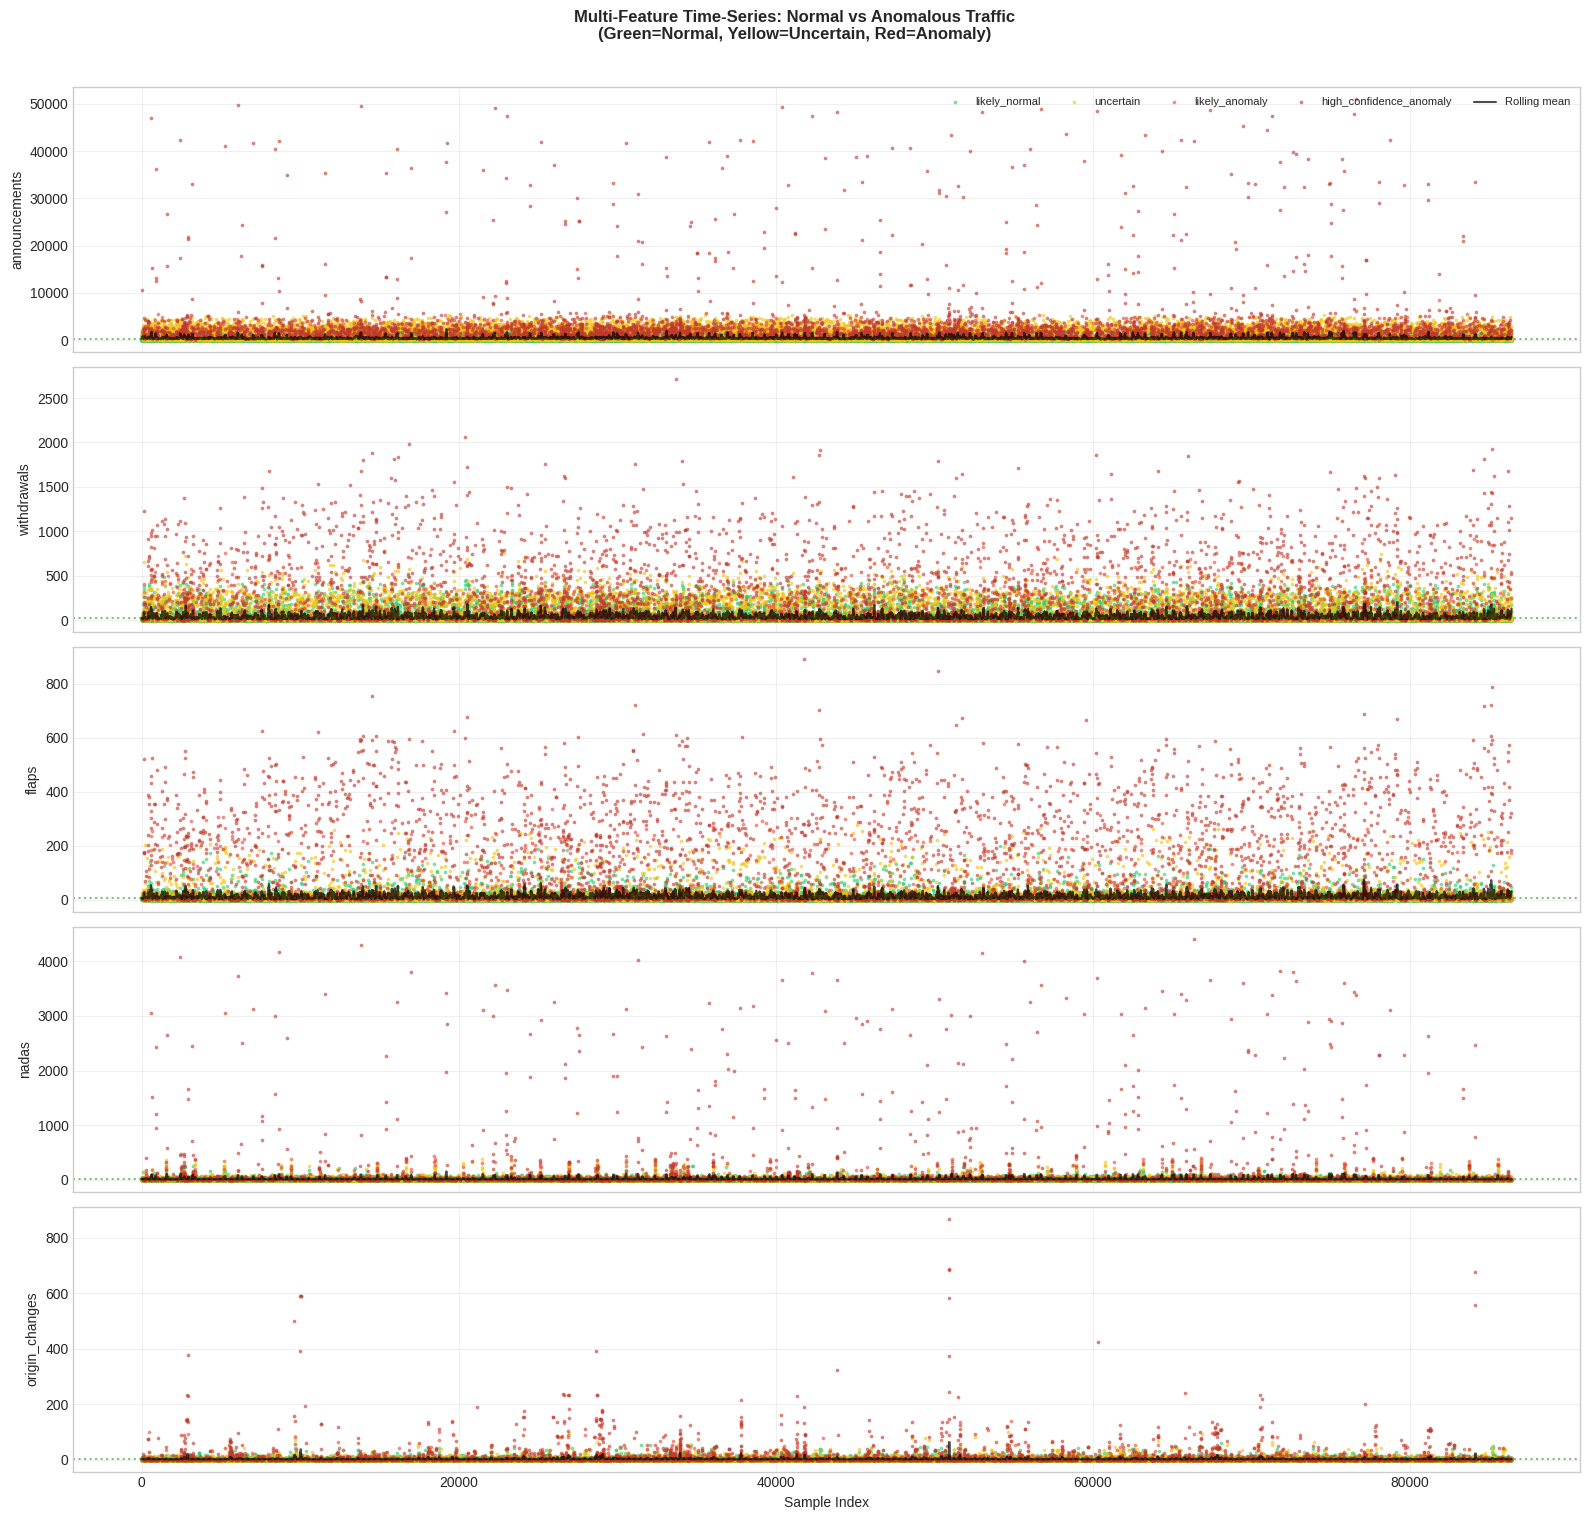

In [29]:
# ============================================
# MULTI-FEATURE COMPARISON: NORMAL vs ANOMALY
# ============================================
print("Creating multi-feature comparison plots...")

# Select key correlated features for BGP analysis
core_features = ['announcements', 'withdrawals', 'flaps', 'nadas', 'origin_changes']
core_features = [f for f in core_features if f in feature_cols]

if len(core_features) >= 3:
    fig, axes = plt.subplots(len(core_features), 1, figsize=(16, 3 * len(core_features)), sharex=True)
    
    # Use full dataset with color coding
    x_all = range(len(ts_df))
    
    colors = {
        'likely_normal': '#2ecc71',
        'uncertain': '#f1c40f', 
        'likely_anomaly': '#e74c3c',
        'high_confidence_anomaly': '#c0392b'
    }
    
    for i, feature in enumerate(core_features):
        ax = axes[i] if len(core_features) > 1 else axes
        
        # Plot each label category
        for label in ['likely_normal', 'uncertain', 'likely_anomaly', 'high_confidence_anomaly']:
            mask = ts_df['discovered_label'] == label
            if mask.sum() > 0:
                indices = np.where(mask)[0]
                values = ts_df.loc[mask, feature].values
                ax.scatter(indices, values, c=colors[label], s=3, alpha=0.5, label=label if i == 0 else '')
        
        # Add rolling mean for reference
        rolling_mean = ts_df[feature].rolling(window=ROLLING_WINDOW, center=True, min_periods=1).mean()
        ax.plot(x_all, rolling_mean, 'k-', linewidth=1.5, alpha=0.7, label='Rolling mean' if i == 0 else '')
        
        ax.set_ylabel(feature, fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        normal_mean = normal_df[feature].mean()
        ax.axhline(y=normal_mean, color='green', linestyle=':', alpha=0.5)
    
    axes[0].legend(loc='upper right', fontsize=8, ncol=5)
    axes[-1].set_xlabel('Sample Index')
    
    plt.suptitle("Multi-Feature Time-Series: Normal vs Anomalous Traffic\n(Green=Normal, Yellow=Uncertain, Red=Anomaly)", 
                 fontsize=12, fontweight='bold', y=1.01)
    plt.tight_layout()
    save_plot(fig, '11_multifeature_comparison')
    plt.show()
else:
    print("Not enough core features available for multi-feature plot")

### 9.1.3 Statistical Tests for Time-Series Stability

Test if the "likely normal" traffic is stationary (stable over time) and follows expected distributions.

In [30]:
# ============================================
# STATISTICAL TESTS FOR TIME-SERIES STABILITY
# ============================================
print("Running statistical tests on 'likely normal' traffic...")

from scipy.stats import shapiro, kstest, normaltest, kurtosis, skew

# Test 1: Augmented Dickey-Fuller for stationarity (if statsmodels available)
try:
    from statsmodels.tsa.stattools import adfuller
    has_statsmodels = True
except ImportError:
    has_statsmodels = False
    print("  Note: statsmodels not available, skipping ADF test")

stability_results = []

for feature in KEY_FEATURES_TIMESERIES[:6]:  # Limit to avoid too much output
    if feature not in normal_df.columns:
        continue
    
    values = normal_df[feature].dropna().values
    
    result = {
        'feature': feature,
        'mean': np.mean(values),
        'std': np.std(values),
        'skewness': skew(values),
        'kurtosis': kurtosis(values),
    }
    
    # Normality test (D'Agostino and Pearson's test)
    if len(values) >= 20:
        try:
            _, p_normal = normaltest(values)
            result['normality_p'] = p_normal
            result['is_normal'] = p_normal > 0.05
        except:
            result['normality_p'] = np.nan
            result['is_normal'] = None
    
    # Stationarity test (ADF)
    if has_statsmodels and len(values) >= 100:
        try:
            adf_result = adfuller(values, maxlag=10)
            result['adf_statistic'] = adf_result[0]
            result['adf_p'] = adf_result[1]
            result['is_stationary'] = adf_result[1] < 0.05
        except:
            result['adf_p'] = np.nan
            result['is_stationary'] = None
    
    stability_results.append(result)

# Display results
print("\n" + "="*90)
print("STATISTICAL STABILITY TESTS FOR 'LIKELY NORMAL' TRAFFIC")
print("="*90)
print(f"{'Feature':<25} {'Mean':>10} {'Std':>10} {'Skew':>8} {'Kurt':>8} {'Normal?':>10} {'Stationary?':>12}")
print("-"*90)

for r in stability_results:
    normal_str = 'Yes' if r.get('is_normal') else 'No' if r.get('is_normal') is not None else 'N/A'
    station_str = 'Yes' if r.get('is_stationary') else 'No' if r.get('is_stationary') is not None else 'N/A'
    print(f"{r['feature']:<25} {r['mean']:>10.2f} {r['std']:>10.2f} {r['skewness']:>8.2f} {r['kurtosis']:>8.2f} {normal_str:>10} {station_str:>12}")

print("\nInterpretation:")
print("  - Skewness: 0 = symmetric, >0 = right-tailed (common for count data)")
print("  - Kurtosis: 0 = normal, >0 = heavy tails (peaks), <0 = light tails")
print("  - Normal?: p>0.05 suggests data could be from normal distribution")
print("  - Stationary?: p<0.05 suggests time-series is stationary (stable)")

Running statistical tests on 'likely normal' traffic...

STATISTICAL STABILITY TESTS FOR 'LIKELY NORMAL' TRAFFIC
Feature                         Mean        Std     Skew     Kurt    Normal?  Stationary?
------------------------------------------------------------------------------------------
announcements                 193.02     215.42     3.86    18.86         No          Yes
withdrawals                    19.36      40.09     5.47    35.52         No          Yes
flaps                           5.76       8.78     8.14   101.27         No          Yes
nadas                           9.13      11.70     5.57    62.16         No          Yes
origin_changes                  1.24       2.66     7.06    78.82         No          Yes
imp_wd                         21.01      17.46     3.21    18.91         No          Yes

Interpretation:
  - Skewness: 0 = symmetric, >0 = right-tailed (common for count data)
  - Kurtosis: 0 = normal, >0 = heavy tails (peaks), <0 = light tails
  - Norma

Comparing distributions: Normal vs Anomalous traffic...
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/12_distribution_comparison.png


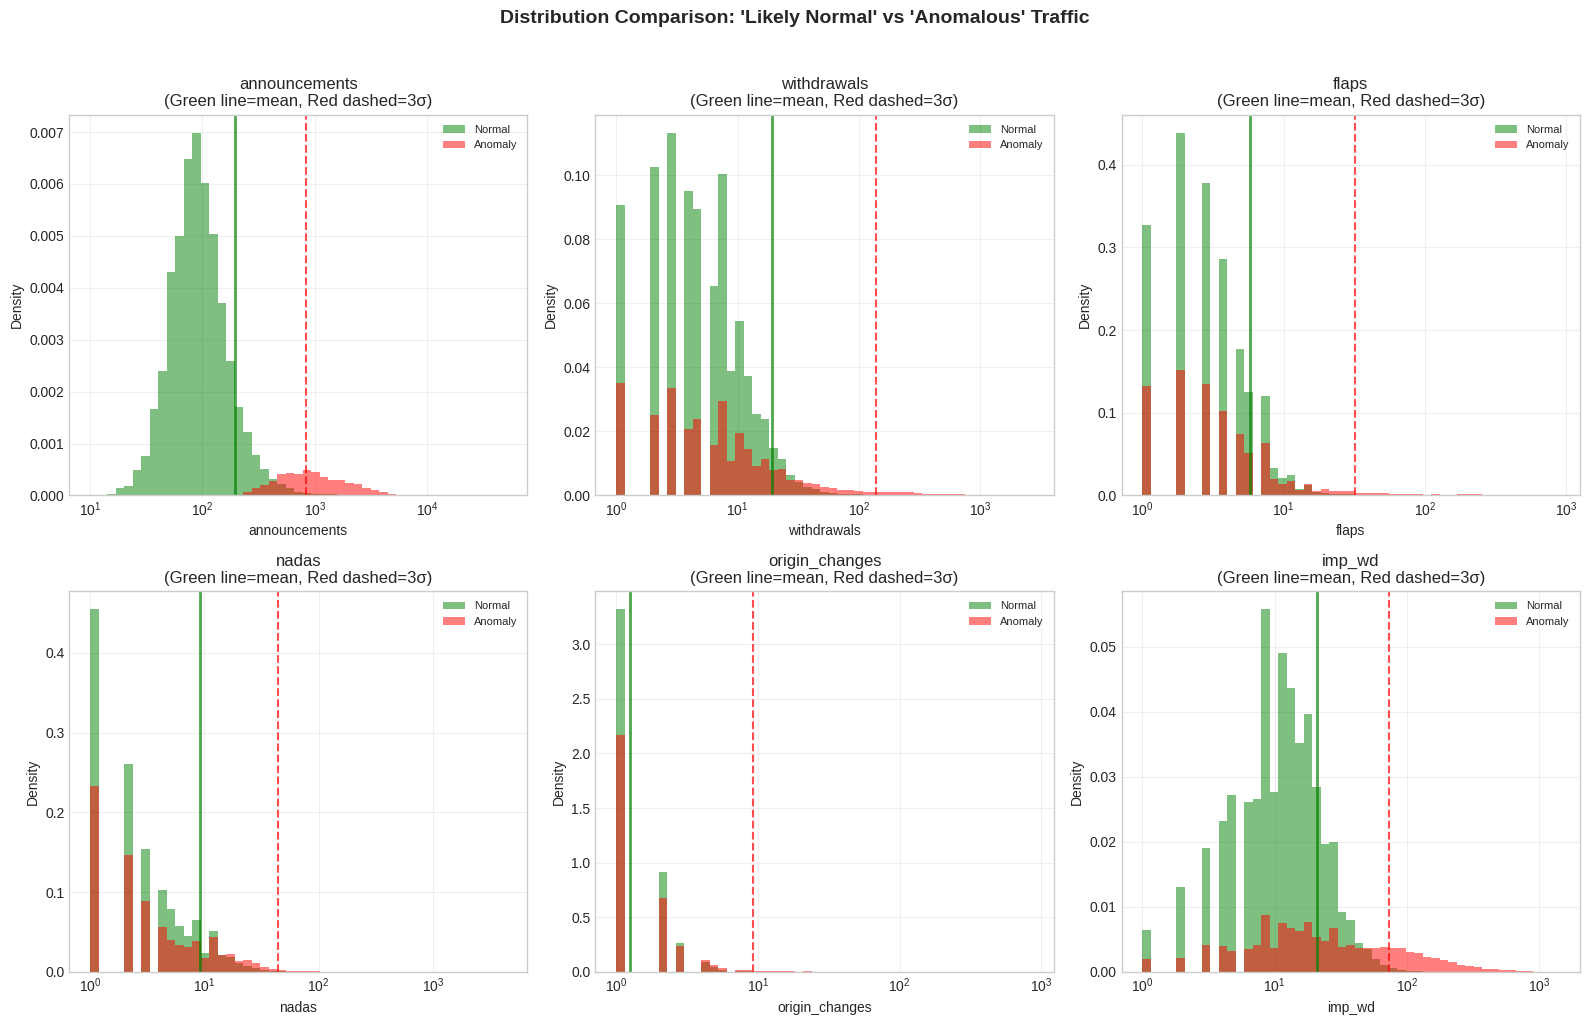

In [31]:
# ============================================
# VISUALIZE DISTRIBUTION DIFFERENCES: NORMAL vs ANOMALY
# ============================================
print("Comparing distributions: Normal vs Anomalous traffic...")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Select top discriminative features
top_features_vis = KEY_FEATURES_TIMESERIES[:6]

for i, feature in enumerate(top_features_vis):
    ax = axes[i]
    
    # Get values
    normal_vals = normal_df[feature].values
    anomaly_vals = anomaly_df[feature].values if len(anomaly_df) > 0 else np.array([])
    
    # Calculate statistics
    normal_mean, normal_std = np.mean(normal_vals), np.std(normal_vals)
    
    # Use log scale if values span many orders of magnitude
    max_val = max(np.max(normal_vals), np.max(anomaly_vals) if len(anomaly_vals) > 0 else 0)
    min_val = min(np.min(normal_vals), np.min(anomaly_vals) if len(anomaly_vals) > 0 else 0)
    use_log = (max_val > 0 and min_val >= 0 and max_val / (min_val + 1) > 100)
    
    if use_log and min_val >= 0:
        # Log-transform for visualization
        bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 50)
        ax.hist(normal_vals + 1, bins=bins, alpha=0.5, label='Normal', color='green', density=True)
        if len(anomaly_vals) > 0:
            ax.hist(anomaly_vals + 1, bins=bins, alpha=0.5, label='Anomaly', color='red', density=True)
        ax.set_xscale('log')
    else:
        ax.hist(normal_vals, bins=50, alpha=0.5, label='Normal', color='green', density=True)
        if len(anomaly_vals) > 0:
            ax.hist(anomaly_vals, bins=50, alpha=0.5, label='Anomaly', color='red', density=True)
    
    # Add threshold lines
    ax.axvline(normal_mean, color='green', linestyle='-', linewidth=2, alpha=0.7)
    ax.axvline(normal_mean + 3*normal_std, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'{feature}\n(Green line=mean, Red dashed=3σ)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Distribution Comparison: 'Likely Normal' vs 'Anomalous' Traffic", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_plot(fig, '12_distribution_comparison')
plt.show()

Computing rolling volatility to detect unstable periods...
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/13_rolling_volatility.png


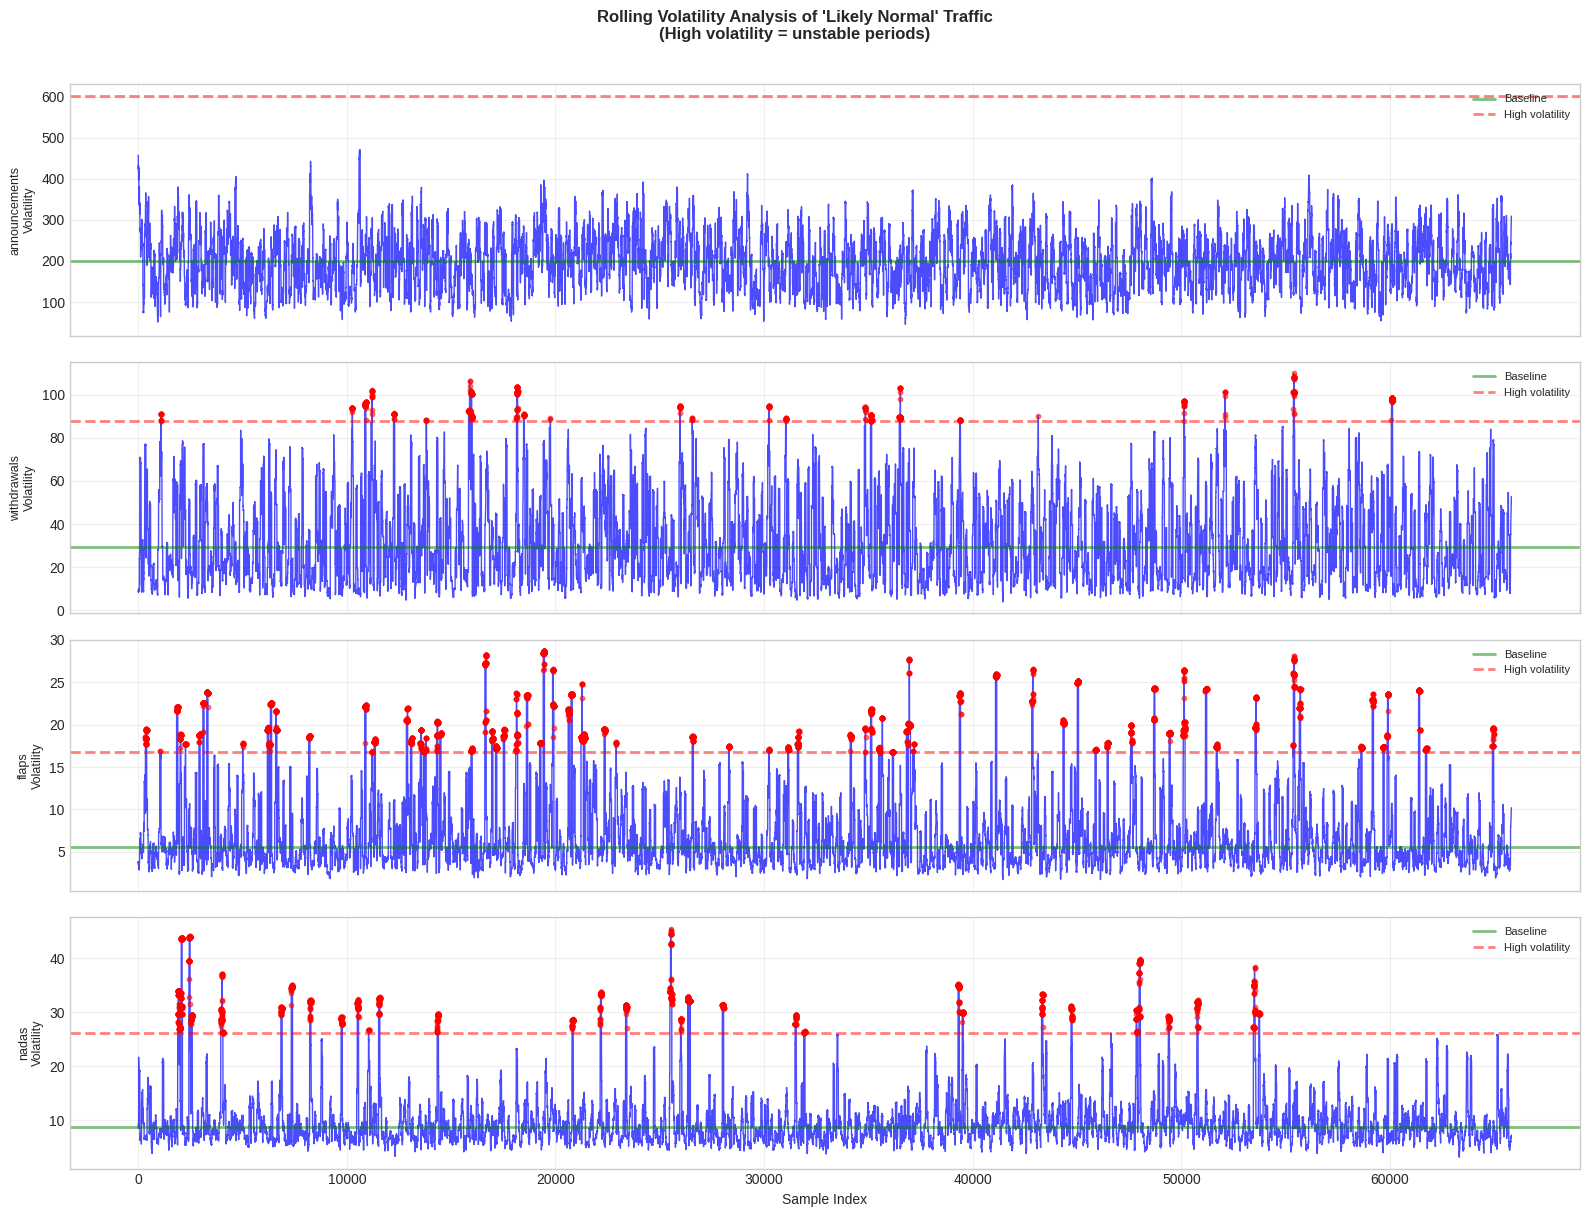


⚠️  HIGH VOLATILITY PERIODS DETECTED:
    withdrawals: 651 samples (0.99%) above 3x baseline volatility
    flaps: 4128 samples (6.27%) above 3x baseline volatility
    nadas: 1955 samples (2.97%) above 3x baseline volatility


In [32]:
# ============================================
# ROLLING VOLATILITY ANALYSIS
# ============================================
print("Computing rolling volatility to detect unstable periods...")

# Calculate rolling standard deviation (volatility) for key features
volatility_df = pd.DataFrame()
volatility_df['index'] = range(len(normal_df))

for feature in KEY_FEATURES_TIMESERIES[:4]:
    if feature in normal_df.columns:
        series = normal_df[feature].values
        rolling_std = pd.Series(series).rolling(window=ROLLING_WINDOW, center=True, min_periods=1).std()
        volatility_df[f'{feature}_volatility'] = rolling_std.values

# Plot volatility over time
fig, axes = plt.subplots(len(KEY_FEATURES_TIMESERIES[:4]), 1, figsize=(16, 3 * len(KEY_FEATURES_TIMESERIES[:4])), sharex=True)

volatility_issues = []

for i, feature in enumerate(KEY_FEATURES_TIMESERIES[:4]):
    ax = axes[i] if len(KEY_FEATURES_TIMESERIES[:4]) > 1 else axes
    col = f'{feature}_volatility'
    
    if col in volatility_df.columns:
        vol = volatility_df[col].values
        
        ax.plot(volatility_df['index'], vol, 'b-', linewidth=1, alpha=0.7)
        
        # Calculate baseline volatility
        baseline_vol = np.median(vol)
        high_vol_threshold = baseline_vol * 3
        
        ax.axhline(y=baseline_vol, color='green', linestyle='-', linewidth=2, alpha=0.5, label='Baseline')
        ax.axhline(y=high_vol_threshold, color='red', linestyle='--', linewidth=2, alpha=0.5, label='High volatility')
        
        # Highlight high volatility periods
        high_vol_mask = vol > high_vol_threshold
        if high_vol_mask.sum() > 0:
            high_vol_indices = np.where(high_vol_mask)[0]
            ax.scatter(high_vol_indices, vol[high_vol_mask], color='red', s=10, alpha=0.5, zorder=5)
            volatility_issues.append((feature, high_vol_mask.sum(), high_vol_mask.sum()/len(vol)*100))
        
        ax.set_ylabel(f'{feature}\nVolatility', fontsize=9)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Sample Index')
plt.suptitle("Rolling Volatility Analysis of 'Likely Normal' Traffic\n(High volatility = unstable periods)", 
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
save_plot(fig, '13_rolling_volatility')
plt.show()

if volatility_issues:
    print("\n⚠️  HIGH VOLATILITY PERIODS DETECTED:")
    for feat, count, pct in volatility_issues:
        print(f"    {feat}: {count} samples ({pct:.2f}%) above 3x baseline volatility")
else:
    print("\n✅ No excessive volatility periods detected in 'likely normal' traffic")

### 9.1.4 Validation Summary Report

Comprehensive assessment of "likely normal" traffic quality.

In [33]:
# ============================================
# FINAL VALIDATION SUMMARY
# ============================================
print("="*80)
print("VALIDATION SUMMARY: 'LIKELY NORMAL' TRAFFIC QUALITY ASSESSMENT")
print("="*80)

# Collect all findings
validation_findings = []

# 1. Peak analysis
total_peaks = sum([v['n_peaks'] for v in peak_summary.values()])
peak_rate = total_peaks / (len(normal_df) * len(peak_summary)) * 100 if peak_summary else 0
if peak_rate > 2:
    validation_findings.append(("WARNING", f"Peak rate: {peak_rate:.2f}% (above normal)", "Review samples with peaks"))
elif peak_rate > 0.5:
    validation_findings.append(("CAUTION", f"Peak rate: {peak_rate:.2f}% (slightly elevated)", "May need attention"))
else:
    validation_findings.append(("PASS", f"Peak rate: {peak_rate:.2f}%", "Within expected range"))

# 2. Suspicious samples analysis
suspicious_rate = suspicious_mask.sum() / len(normal_df) * 100
if suspicious_rate > 5:
    validation_findings.append(("WARNING", f"Suspicious samples: {suspicious_rate:.2f}%", "Consider reclassifying"))
elif suspicious_rate > 1:
    validation_findings.append(("CAUTION", f"Suspicious samples: {suspicious_rate:.2f}%", "Monitor closely"))
else:
    validation_findings.append(("PASS", f"Suspicious samples: {suspicious_rate:.2f}%", "Acceptable level"))

# 3. Volatility check
vol_rate = sum([v[2] for v in volatility_issues]) / len(volatility_issues) if volatility_issues else 0
if vol_rate > 5:
    validation_findings.append(("WARNING", f"High volatility periods: {vol_rate:.2f}%", "Traffic may be unstable"))
elif vol_rate > 1:
    validation_findings.append(("CAUTION", f"High volatility periods: {vol_rate:.2f}%", "Some instability detected"))
else:
    validation_findings.append(("PASS", f"High volatility periods: {vol_rate:.2f}%", "Traffic is stable"))

# 4. Distribution check
high_skew = sum([1 for r in stability_results if abs(r['skewness']) > 2])
if high_skew > len(stability_results) / 2:
    validation_findings.append(("CAUTION", f"Highly skewed features: {high_skew}/{len(stability_results)}", "Non-normal distributions"))
else:
    validation_findings.append(("PASS", f"Skewed features: {high_skew}/{len(stability_results)}", "Expected for count data"))

# Print summary
print("\n" + "-"*80)
for status, finding, recommendation in validation_findings:
    if status == "PASS":
        icon = "✅"
    elif status == "CAUTION":
        icon = "⚠️ "
    else:
        icon = "❌"
    print(f"{icon} [{status}] {finding}")
    print(f"   → {recommendation}")
    print()

# Overall verdict
warnings = sum([1 for v in validation_findings if v[0] == "WARNING"])
cautions = sum([1 for v in validation_findings if v[0] == "CAUTION"])

print("-"*80)
if warnings > 0:
    print("🔴 VERDICT: 'LIKELY NORMAL' TRAFFIC REQUIRES REVIEW")
    print("   Some samples may be misclassified. Manual inspection recommended.")
elif cautions > 1:
    print("🟡 VERDICT: 'LIKELY NORMAL' TRAFFIC IS ACCEPTABLE WITH MINOR CONCERNS")
    print("   Consider investigating flagged samples before using for training.")
else:
    print("🟢 VERDICT: 'LIKELY NORMAL' TRAFFIC IS VALIDATED")
    print("   The labeled normal traffic shows consistent, stable patterns.")

print("="*80)

# Save suspicious samples for manual review
if suspicious_mask.sum() > 0:
    suspicious_output = normal_df.iloc[suspicious_mask].copy()
    suspicious_output['max_z_score'] = max_z_scores[suspicious_mask]
    suspicious_path = output_dir / f"{input_path.stem}_suspicious_normal.csv"
    suspicious_output.to_csv(suspicious_path, index=False)
    print(f"\n📁 Saved {len(suspicious_output)} suspicious 'likely normal' samples to:")
    print(f"   {suspicious_path}")

VALIDATION SUMMARY: 'LIKELY NORMAL' TRAFFIC QUALITY ASSESSMENT

--------------------------------------------------------------------------------
⚠️  [CAUTION] Peak rate: 1.82% (slightly elevated)
   → May need attention

❌ [WARNING] Suspicious samples: 12.55%
   → Consider reclassifying

⚠️  [CAUTION] High volatility periods: 3.41%
   → Some instability detected

⚠️  [CAUTION] Highly skewed features: 6/6
   → Non-normal distributions

--------------------------------------------------------------------------------
🔴 VERDICT: 'LIKELY NORMAL' TRAFFIC REQUIRES REVIEW
   Some samples may be misclassified. Manual inspection recommended.

📁 Saved 8258 suspicious 'likely normal' samples to:
   /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_suspicious_normal.csv


Analyzing hourly patterns in 'likely normal' traffic...
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/14_hourly_patterns.png


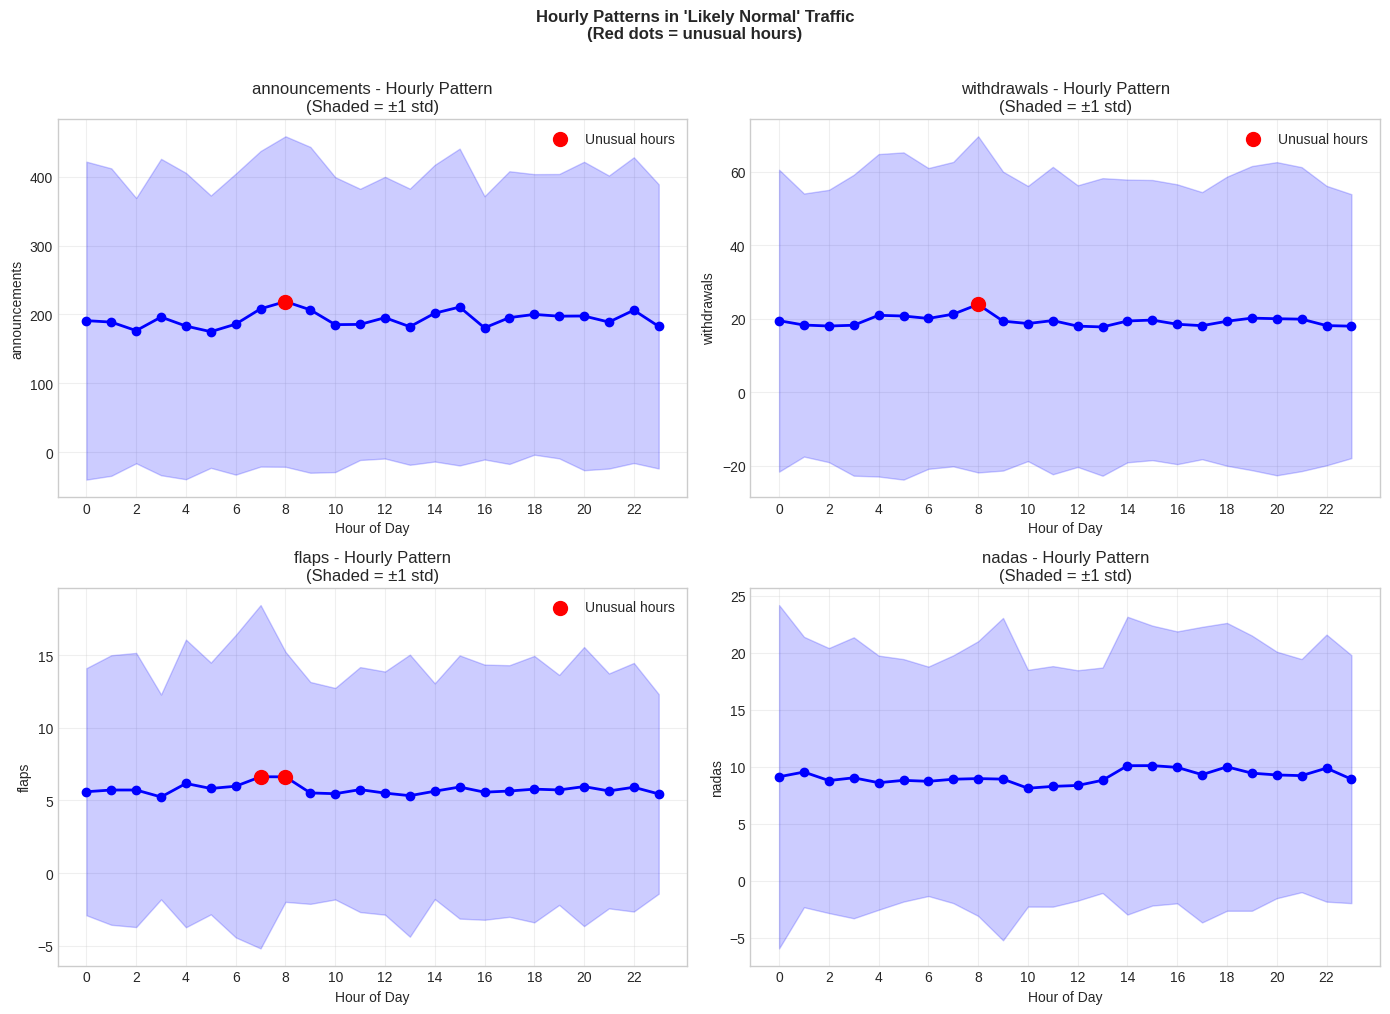

✅ Hourly pattern analysis complete
   Check for unexpected spikes at certain hours of the day


In [34]:
# ============================================
# BONUS: HOURLY PATTERN ANALYSIS (if time data available)
# ============================================
if has_time and TIME_COL in normal_df.columns:
    print("Analyzing hourly patterns in 'likely normal' traffic...")
    
    normal_df_time = normal_df.copy()
    normal_df_time['hour'] = pd.to_datetime(normal_df_time[TIME_COL]).dt.hour
    
    # Compute hourly statistics
    hourly_stats = normal_df_time.groupby('hour')[KEY_FEATURES_TIMESERIES[:4]].agg(['mean', 'std'])
    
    # Plot hourly patterns
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(KEY_FEATURES_TIMESERIES[:4]):
        ax = axes[i]
        
        means = hourly_stats[(feature, 'mean')]
        stds = hourly_stats[(feature, 'std')]
        hours = means.index
        
        ax.plot(hours, means, 'b-', linewidth=2, marker='o')
        ax.fill_between(hours, means - stds, means + stds, alpha=0.2, color='blue')
        
        # Highlight unusual hours (>2 std from daily mean)
        daily_mean = means.mean()
        daily_std = means.std()
        unusual_hours = hours[(means > daily_mean + 2*daily_std) | (means < daily_mean - 2*daily_std)]
        
        if len(unusual_hours) > 0:
            ax.scatter(unusual_hours, means[unusual_hours], color='red', s=100, zorder=5, 
                       label=f'Unusual hours')
            ax.legend()
        
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel(feature)
        ax.set_title(f'{feature} - Hourly Pattern\n(Shaded = ±1 std)')
        ax.set_xticks(range(0, 24, 2))
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("Hourly Patterns in 'Likely Normal' Traffic\n(Red dots = unusual hours)", 
                 fontsize=12, fontweight='bold', y=1.01)
    plt.tight_layout()
    save_plot(fig, '14_hourly_patterns')
    plt.show()
    
    print("✅ Hourly pattern analysis complete")
    print("   Check for unexpected spikes at certain hours of the day")
else:
    print("No timestamp data available for hourly pattern analysis")

## 10. Compare with Existing Labels (if available)

Comparison: Existing Labels vs Discovered Labels

Normalized by existing label (row-wise):
discovered  high_confidence_anomaly  likely_anomaly  likely_normal  uncertain
existing                                                                     
normal                        0.053            0.02          0.762      0.165
All                           0.053            0.02          0.762      0.165
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_plots/08_label_comparison.png


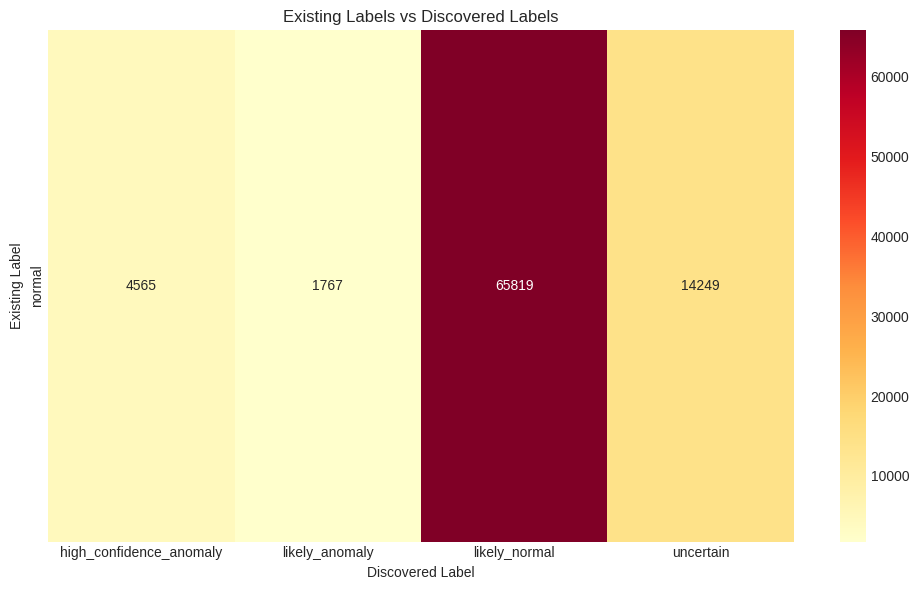


📋 RECOMMENDATIONS:
   ℹ️ 'normal': 76.2% normal, 7.3% anomalous


In [35]:
if EXISTING_LABEL_COL and EXISTING_LABEL_COL in df.columns:
    # Get existing labels for valid samples
    existing_labels = df.loc[valid_mask, EXISTING_LABEL_COL].values
    
    print("Comparison: Existing Labels vs Discovered Labels")
    print("="*70)
    
    comparison_df = pd.DataFrame({
        'existing': existing_labels,
        'discovered': discovered_labels
    })
    
    # Cross-tabulation
    cross_tab = pd.crosstab(comparison_df['existing'], comparison_df['discovered'], 
                            margins=True, normalize='index')
    
    print("\nNormalized by existing label (row-wise):")
    print(cross_tab.round(3))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_tab_counts = pd.crosstab(comparison_df['existing'], comparison_df['discovered'])
    sns.heatmap(cross_tab_counts, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
    plt.title('Existing Labels vs Discovered Labels')
    plt.xlabel('Discovered Label')
    plt.ylabel('Existing Label')
    plt.tight_layout()
    save_plot(fig, '08_label_comparison')
    plt.show()
    
    # Recommendations
    print("\n📋 RECOMMENDATIONS:")
    for existing_label in df[EXISTING_LABEL_COL].unique():
        mask = existing_labels == existing_label
        discovered_dist = pd.Series(discovered_labels[mask]).value_counts(normalize=True)
        
        anomaly_rate = discovered_dist.get('high_confidence_anomaly', 0) + discovered_dist.get('likely_anomaly', 0)
        normal_rate = discovered_dist.get('likely_normal', 0)
        
        if 'normal' in str(existing_label).lower() and anomaly_rate > 0.2:
            print(f"   ⚠️ '{existing_label}': {anomaly_rate*100:.1f}% look anomalous - review these samples!")
        elif 'attack' in str(existing_label).lower() or 'hijack' in str(existing_label).lower():
            if normal_rate > 0.3:
                print(f"   ⚠️ '{existing_label}': {normal_rate*100:.1f}% look normal - possible mislabeling!")
            else:
                print(f"   ✅ '{existing_label}': Looks correctly labeled ({anomaly_rate*100:.1f}% detected as anomalous)")
        else:
            print(f"   ℹ️ '{existing_label}': {normal_rate*100:.1f}% normal, {anomaly_rate*100:.1f}% anomalous")
else:
    print("No existing labels to compare with.")

## 11. Save Results

In [31]:
# Create final results dataframe
results_df = df.copy()

# Add results for valid samples
results_df['iso_forest_score'] = np.nan
results_df['lof_score'] = np.nan
results_df['statistical_score'] = np.nan
results_df['elliptic_score'] = np.nan
results_df['cluster'] = -1
results_df['anomaly_votes'] = np.nan
results_df['consensus_score'] = np.nan
results_df['discovered_label'] = 'invalid'

results_df.loc[valid_mask, 'iso_forest_score'] = iso_scores
results_df.loc[valid_mask, 'lof_score'] = lof_scores
results_df.loc[valid_mask, 'statistical_score'] = stat_scores
results_df.loc[valid_mask, 'elliptic_score'] = elliptic_scores
results_df.loc[valid_mask, 'cluster'] = cluster_labels
results_df.loc[valid_mask, 'anomaly_votes'] = anomaly_votes
results_df.loc[valid_mask, 'consensus_score'] = consensus_score
results_df.loc[valid_mask, 'discovered_label'] = discovered_labels

# Save to file
input_path = Path(INPUT_FILE)
output_dir = Path(OUTPUT_DIR) if OUTPUT_DIR else input_path.parent
output_path = output_dir / f"{input_path.stem}_discovered.csv"

results_df.to_csv(output_path, index=False)
print(f"✅ Results saved to: {output_path}")

# Save anomalies separately
anomalies_df = results_df[results_df['discovered_label'].isin(['high_confidence_anomaly', 'likely_anomaly'])]
if len(anomalies_df) > 0:
    anomalies_path = output_dir / f"{input_path.stem}_anomalies.csv"
    anomalies_df.to_csv(anomalies_path, index=False)
    print(f"✅ Anomalies saved to: {anomalies_path} ({len(anomalies_df)} samples)")

✅ Results saved to: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_discovered.csv
✅ Anomalies saved to: /home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN_v2/rrc05_updates_20251216_extracted_anomalies.csv (6333 samples)
